## 0. IMPORT REQUIRED LIBRARIES

In [2]:
# import the necessary libraries
import requests
import json
import time
import datetime
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import math
from sklearn import naive_bayes
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics

## 1. GETTING RAW DATA

### 1.1. Getting summonerId

#### 1.1.1. Getting summonerId of ranks below master

<span style ="font-size: 16px;">Normally, ranks are divided into 4 small divisions; however, from master onwards, ranks no longer have divisions, which makes their division only I instead of I, II, III, and IV. Also, the higher the rank, the less the number of players, some doesn't even have enough 200. Therefore, for these higher ranks, we will have another way to work with them</span><br>

In [1]:
def get_low_tier_summonerId(api_key):
    """Get 200 summonerId for each rank of 7 ranks from iron to diamond, and save them

    Args:
        api_key (string): the api key to make requests. Our api key resets after every 24 hours so we will have to do like this
    """

    # All the ranks that we want to work with
    tiers = ["IRON", "BRONZE", "SILVER", "GOLD", "PLATINUM", "EMERALD", "DIAMOND"]

    # 7 first ranks each has 4 divison : I, II, III, IV. So we will get 50 summonerId for each divion
    divisions = ["I", "II", "III", "IV"]

    for tier in tiers:
        summoner_ids=[] # A list consists of summonerId of the rank, we will get 200 summonerId for each rank
        for division in divisions:
            url = f"https://vn2.api.riotgames.com/lol/league-exp/v4/entries/RANKED_SOLO_5x5/{tier}/{division}?page=1&api_key={api_key}"
            response = requests.get(url)
            if response.status_code == 200:
                data = response.json() # data is a list of dicts, each contains information about an account. We will only get the summonerId
                summoner_ids +=[player['summonerId'] for player in data[:50]] #get 50 elements from data, and add their summonerId value to the list
            else:
                print("Failed to retrieve account PUUID. Status Code:", response.status_code)

        # check if we got enough 200 summonerId. If true, save them to a json file
        if len(summoner_ids) == 200:
            with open(f"summoner_ids/{tier}_summoner_ids.json", 'w', encoding='utf-8') as file:
                json.dump(summoner_ids, file, ensure_ascii=False, indent=4)
            print(f"got {tier}'s 200 summonerIds succesfully!")
        else:
            print(f"something is wrong! {tier} has ", len(summoner_ids), "summonerIds!")

#### 1.1.2.Getting summonerId of ranks from master onwards

<span style ="font-size: 16px;">Now, ranks no longer have divisions, so the division will always be I.</span><br>
<span style ="font-size: 16px;">These higher ranks have a limited number of players; Therefore, if a rank's number of players is less than 200, we will get as many as possible, and compensate for this by increasing the number of matches we get from each players.</span><br>
<span style ="font-size: 16px;">Instead of getting the summonerIds of each rank in one run, we will do each seperately to handle errors and check out the number of players we get</span><br>

<span style ="font-size: 16px;">In these 3 ranks, we don't know if the number of players is more than 200 or not; Therefore, we will get all the summonerId first.</span><br>
<span style ="font-size: 16px;">After that, we check if the number is more than 200. If it does, remove the unecessary Ids.</span><br>
<span style ="font-size: 16px;">For the ranks that its number of players is less than 200, after getting all of its summonerId, we will check the number with the real number via ingame leaderboard. After making sure they are equal, save it</span><br>

In [2]:
def get_high_tier_summonerId(api_key, tier):
    """Get 200 summonerId of the given tier(rank), and save them

    Args:
        api_key (_tring): the api key to make requests
        tier (string): the tier you want to get its player's sumonnerId

    Returns:
        list: a list of 200 summonerId of the given tier
    """

    # A list to store summonerId of the rank
    summoner_ids=[]

    url = f"https://vn2.api.riotgames.com/lol/league-exp/v4/entries/RANKED_SOLO_5x5/{tier}/I?page=1&api_key={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json() # the data we get is a list of dicts, each dict contains each player's data
        summoner_ids +=[player['summonerId'] for player in data] # we only need the player's summonerId
    else:
        print("Failed to retrieve account PUUID. Status Code:", response.status_code)
    if len(summoner_ids) > 200:
        summoner_ids = summoner_ids[:200]
    print("got", len(summoner_ids), f"summonerIds from rank {tier}")    #print out the number of summonerIds to check
    return summoner_ids

In [ ]:
# after checking, if nothing is wrong, we save
# for example:
master_summoner_ids = get_high_tier_summonerId('RGAPI-898a3f42-867f-410a-9845-ca10dd463281', 'master')
with open(f"summoner_ids/master_summoner_ids.json", 'w', encoding='utf-8') as file:
    json.dump(master_summoner_ids, file, ensure_ascii=False, indent=4)

### 1.2. Getting puuid from summonerId

<span style ="font-size: 16px;">Now we will need to get the player's puuid from their summonerId by sending 200 requests for each 200 players of a rank. Doing all 10 ranks once will take a really long time and any error will be a disaster;Therefore, we will work with each rank seperately.</span><br>

In [3]:
def get_puuid(api_key, tier):
    """get 200 puuid from the 200 summonerId of the given tier, and save them

    Args:
        api_key (string): the api key to make requests
        tier (string): the tier you want to get its player's puuid
    """

    # path of the json file that stores the rank's summonerIds
    path= f"summoner_ids/{tier}_summoner_ids.json"

    # A list to store puuids
    puuids = []

    # Get summonerIds from the json file
    with open(path, "r") as file:
        summoner_ids = json.load(file)

    # check its number:
    print(len(summoner_ids))

    for summoner_id in summoner_ids:
        url = f"https://vn2.api.riotgames.com/lol/summoner/v4/summoners/{summoner_id}?api_key={api_key}"
        retries = 12
        for i in range(retries):
            response = requests.get(url)
            if response.status_code == 200:
                data = response.json() # data responded is a dict that contains some basic information of the account, we need its puuid
                puuids.append(data["puuid"])
                break
            elif response.status_code == 429:
                time.sleep(6)
            else:
                print("Failed to retrieve account PUUID. Status Code:", response.status_code)
                break

    # check the number of puuids after requesting
    print("got", len(puuids), f"of rank {tier}")

    # if nothing goes wrong, save the puuids
    if len(puuids) == len(summoner_ids):
        with open(f"puuids/{tier}_puuids.json", 'w', encoding='utf-8') as file:
            json.dump(puuids, file, ensure_ascii=False, indent=4)
        print("Got all the puuid successfully")

### 1.3. Getting matchId using puuid

<span style ="font-size: 16px;">  -  Now we need to get 2000 unique matchIds for each rank. We've already got 200 players's puuid for each rank (most of it). Idealy, we will want to get 10 matchIds for each puuid. However, there are circumstances where this is impossible:</span><br>
<span style ="font-size: 16px;">  -  Ranks like master, grandmaster and challenger has very few players, the probality of them facing each other in a match is really high(each match has 10 players, and challenger, for example, has about 150 players). Because of that, getting just 10 matches for each puuid won't be enough for these ranks, so a reserve set - reserve_matchids is created to store unique exceeding matchIds of a puuid after getting enough 10 from it. After going through all the puuids in the rank, if the number of unique matchIds is less than 2000, we will add matchIds from reserve_matchids in.</span><br>
<span style ="font-size: 16px;">  -  Also, players of 2 different ranks can also be in the same match, so we will need to store all the matchIds we got to a set and check if any new matchId we want to add is already in it.</span><br>
<span style ="font-size: 16px;">  -  For the highest rank - challenger, since it has even less player, even getting all of the matchIds won't be enough. Luckily, these players play alot, so we will just need to wait for them to play more, by get the matchIds once, and do it again few days later until we get enough 2000 unique matches.</span><br>
<span style ="font-size: 16px;">  -  Similar to puuId, we will have to send 1 request for each player. Doing 9 ranks at the same time is not a wise choice and so we will do it rank by rank</span><br>

In [8]:
def get_matchId(api_key, tier, match_ids):
    """get 2000 unique matchId of the given tier, from the puuid got from that rank

    Args:
        api_key (string): the api key to make requests
        tier (string): the rank you want to get its matchId
        match_ids (set): the set that stores all the matchId of all the ranks

    Returns:
        set: a set of 2000 matchId of the given rank
    """

    # create a set to store the rank's matchIds
    matchids = set({})

    # create the reserve set
    reserve_matchids=set({})

    # get the puuids of the rank
    path = f"puuids/{tier}_puuids.json"
    with open(path, "r") as file:
        puuids = json.load(file)

    for puuid in puuids:
        url = f"https://sea.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid}/ids?type=ranked&start=0&count=20&api_key={api_key}"
        retries = 12
        for i in range(retries):
            response = requests.get(url)
            if response.status_code == 200:
                data = response.json() # data is a list of 20 matchIds - 20 latest matches of that account
                count = 0 # count how many matchIds of this puuid have been put to the set
                for i in range(len(data)):
                    if data[i] not in match_ids: # check if the matchId is already in the set
                        if count < 10:
                            match_ids.add(data[i])
                            matchids.add(data[i])
                            count+=1
                        elif count == 10: # if the puuid has dedicated 10 unique matchIds to the set, add the rest to reserve
                            reserve_matchids.add(data[i])
                            count+=1
                            break
                break
            elif response.status_code == 429:
                time.sleep(6)
            else:
                print("Failed to retrieve account PUUID. Status Code:", response.status_code)
                break

    # Check if the number of matchIds is less than 2000 to compensate for it
    if len(matchids) < 2000:
        ids_to_add = list(reserve_matchids)[:2000-len(matchids)]
        match_ids.update(ids_to_add)
        matchids.update(ids_to_add)

    # Check the result
    print("from", len(match_ids), f"matchIds of rank {tier}")
    print("got", len(matchids), "matchIds")
    return matchids

In [ ]:
# if nothing go wrong, save
# for example:
api_key = "RGAPI-898a3f42-867f-410a-9845-ca10dd463281"
tier = "master"
match_ids = set({})
master_match_ids = get_matchId(api_key, tier, match_ids)
with open(f"match_ids/{tier}_puuids.json", 'w', encoding='utf-8') as file:
    json.dump(master_match_ids, file, ensure_ascii=False, indent=4)

### 1.4. Getting data of 20000 matches

<span style ="font-size: 16px;">Since the limit of the api key is 100 requests/minute, and each response of a request is a 150kb file, getting 2000 matches of a singular rank alone takes approximately 40 minutes, and all 20000 matches would be around 3gb.</span><br>
<span style ="font-size: 16px;">That's why we will get 2000 matches of a rank each time, to get the data faster using 3 devices, avoid wasting time just to receive some random error, and lagging when trying to save all the data to file</span><br>

In [ ]:
def get_match_data(api_key, tier):
    """Get the data of each match from 2000 matchId of the given rank

    Args:
        api_key (string): api key to make requests
        tier (string): the rank you want to get its matches's data

    Returns:
        list: a list containing data of 2000 matches
    """

    # A list containing data of 2000 matches
    match_datas = []

    # Get a list of 2000 matchIds of the rank
    with open(f"match_ids/{tier}_matchids.json", "r") as file:
        match_ids = json.load(file)

    for match_id in match_ids:
        url = f"https://sea.api.riotgames.com/lol/match/v5/matches/{match_id}?api_key={api_key}"
        retries = 12
        for i in range(retries):
            response = requests.get(url)
            if response.status_code == 200:
                match_datas.append(response.json())
                # Check for progress
                if len(match_datas)%100==0:
                    print("got the data of", len(match_datas), "matches")
                break
            elif response.status_code == 429:
                time.sleep(6)
            else:
                print("Failed to retrieve account PUUID. Status Code:", response.status_code)
                break
    return match_datas 

In [ ]:
# after checking, we save
# for challenger, we save the result of the first run, then add more later
# for example:
api_key = "RGAPI-898a3f42-867f-410a-9845-ca10dd463281"
tier = "iron"
iron_match_datas = get_match_data(api_key, tier)
with open(f"match_datas/{tier}_match_datas", 'w', encoding='utf-8') as file:
        json.dump(iron_match_datas, file, ensure_ascii=False, indent=4)

## 2. Data cleaning

### 2.1. Some information about data of a match

<span style ="font-size: 16px;">For each matchId, we will have a json file of about 150kb after requesting the data.</span><br>
<span style ="font-size: 16px;">Since this is just a small project and we will only use some basic information, all we need are some information mentioned below, together with some examples:</span><br>

In [21]:
# Data of a match, here saved in test.json
with open("test.json", 'r') as file:
    match_data = json.load(file)

# match_data is a dict with 2 keys metadata and info. we only need the value of info
info = match_data["info"]

"""
info is a dict with 16 keys, we will only go for participants, gameCreation, gameDuraion and teams:
    - participants's value is a 1 list of 10 elements representing 10 players of that match
    - teams's value is a list of 2 elements representing 2 teams blue/red
    - gameCreation's value is a timestamp in miliseconds that tells the time when the match starts
    - gameDuration's value is the time the match lasts, measured in seconds
"""
participants = info["participants"]
teams = info['teams']
gameCreation = info['gameCreation']
gameDuration = info['gameDuration']

"""
Each player has a dict with 132 keys which are data of that player.
We will only get 10 data about championId, teamPosition, item0, item1, item2, item3, item4, item5 and win:
    - championId is the id of the champion used by the player
    - teamPosition is the role that player takes charge of, among 5 roles: TOP, JUNGLE, MIDDLE, BOTTOM, UTILITY
    - iteam1, iteam2,... are the items of that player at the end of the match. We will get data of big items only
    - win is a bool true/false corresponds to win/lose
"""
player = participants[0]
championId = player['championId']
teamPosition = player['teamPosition']
item0 = player["item0"]
win = player['win']

"""
Each team has a dict with 4 keys: bans, objectives, teamId and win:
    - bans is a list with 5 elements representing 5 champions that the team banned from being chose in that match (each team has 5 bans)
        + Each element of bans is a dict with 2 keys: championId(Id of the banned champion) and pickTurn(the turn at which the champion is banned),
          this represent a ban (We only need championId to know which champion is banned)
              *for example: Leesin got banned at turn 1, the dict will be: {championId : 64, pickTurn : 1}
    - objectives are targets(muc tieu) that the team tookdown(killed), it is a dict with 7 keys:
      baron, champion(tuong), dragon(rong), horde(sau hu khong), inhibitor(nha linh), riftHerald(su gia khe nut) and tower(tru).
      Each objective is given by a dict with 2 keys: first and kills:
        + first is a bool true/false that tells whether that team tookdown that target first (before the other team does it)
              *for example: if first of champion of blue team is True, that means blue tookdown a player
               of red team before any of their player is tookdown by red
               in other words, blue team is the first team to get a kill
        + kills is the number of times the team tookdown that target
              *for example: dragon's skills of blue team is 2, that means blue team killed 2 dragons
    - teamId is the id of the team, 100 is blue va 200 is red (we won't use teamId for the project)
    - win is a bool that tells whether the win has won the match
"""
team = teams[0]
bans = list(team['bans'][i]['championId'] for i in range(5))
objectives = team['objectives']
team_win = team['win']

# Check the stats:
print("game start date:", datetime.datetime.fromtimestamp(gameCreation / 1000.0))
print("game duration:", str("{:.2f}".format(gameDuration/60)), "minutes")

print("player1 basic infos:")
print(championId, teamPosition, item0, win)
print()
print("team1 basic infos:")
print(bans)
for objective in objectives:
    print(objective)
    print(objectives[objective])
print(team_win)

game start date: 2024-10-19 16:20:13.153000
game duration: 27.87 minutes
player1 basic infos:
777 TOP 1055 False

team1 basic infos:
[523, 121, 203, 104, 36]
baron
{'first': False, 'kills': 0}
champion
{'first': True, 'kills': 22}
dragon
{'first': True, 'kills': 2}
horde
{'first': True, 'kills': 5}
inhibitor
{'first': False, 'kills': 0}
riftHerald
{'first': True, 'kills': 1}
tower
{'first': True, 'kills': 5}
False


### 2.2. Cleaning data

<span style ="font-size: 16px;">Now that we know what we need from a match, it's time we get it and reduce the size of our data</span><br>

In [2]:

def clean_data():
    """get the necessary information from the huge chunk of data

    Returns:
        tuple: a tuple with 4 elements: first_objective_info, champion_info, champion_big_items and champion_role
    """
    # create a dict to store information about total win/lose when the team got the objective first
    # This will later be used to calculate the probality of winning when the team is the first team to takedown a specific objective
    first_objective_info = {'baron' : {'win' : 0, 'lose' : 0}, 'champion' : {'win' : 0, 'lose' : 0}, 'dragon' : {'win' : 0, 'lose' : 0},
                            'horde' : {'win' : 0, 'lose' : 0}, 'inhibitor' : {'win' : 0, 'lose' : 0},
                            'riftHerald' : {'win' : 0, 'lose' : 0}, 'tower' : {'win' : 0, 'lose' : 0}}
    
    # create a list to store all the matches's timestamp, later used to find out times that players usually play
    timestamp_list = []

    # create a list to store all the matches's gameDuration, used for game time statistics
    gameDuration_list = []

    # create a dict to store each player's total role taken, used to find out popular roles
    player_roles = {}

    # get the list of big items's id and their name
    with open("dragon_data/item_list.json", 'r') as file:
        list_of_big_items = json.load(file)

    # create a dict champion_info to store each champion's id, name, total win, total lose and total ban
    # create a dict champion_big_items to store all the items bought for each champion and their number, later used to get 3 most bought items
    # create a dict champion_role to store each champion's number of times used for each role, later used to get the champions's roles
    with open("dragon_data/champion_list.json", 'r') as file:
        champions = json.load(file) #a dict of all the champions's id and their name
        champion_info = {key : {'name' : champions[key], 'win' : 0, 'lose' : 0, 'ban' : 0} for key in champions}
        champion_big_items = {key : {} for key in champions}
        champion_role = {key : {'TOP' : {'win' : 0, 'lose' : 0}, 'JUNGLE' : {'win' : 0, 'lose' : 0}, 'MIDDLE' : {'win' : 0, 'lose' : 0},
                                'BOTTOM' : {'win' : 0, 'lose' : 0}, 'UTILITY' : {'win' : 0, 'lose' : 0}} for key in champions}

    tiers = ['iron', 'bronze', 'silver', 'gold', 'platinum', 'emerald', 'diamond', 'master', 'grandmaster', 'challenger']

    for tier in range(10):
        # load the data of 2000 matches of the rank
        with open(f"matchinfo/{tiers[tier]}.json", 'r', encoding="utf8") as file:
            match_datas = json.load(file)

        for each_match in match_datas:
            timestamp_list.append(each_match['info']['gameCreation'])
            gameDuration_list.append(each_match['info']['gameDuration'])
            for i in range(10):
                # get information of the ith player of the match
                player = each_match["info"]["participants"][i]
                player_puuid = player['puuid']
                if player_puuid not in player_roles:
                    player_roles[player_puuid] = {'TOP': 0, 'JUNGLE' : 0, 'MIDDLE': 0, 'BOTTOM' : 0, 'UTILITY' : 0}
                if player['teamPosition'] != "":
                    player_roles[player_puuid][player['teamPosition']] += 1
                championId = str(player['championId']) # the player's championId
                if tier > 3: #only work with ranks higher than gold
                    if player['win'] == True:
                        champion_info[championId]['win'] += 1
                    else:
                        champion_info[championId]['lose'] += 1
                    if player['teamPosition'] != "":
                        if player['win'] == True:
                            champion_role[championId][player['teamPosition']]['win'] += 1
                        else:
                            champion_role[championId][player['teamPosition']]['lose'] += 1
                for i in range(5):
                    if str(player[f"item{i}"]) in list_of_big_items:
                        if player[f"item{i}"] not in champion_big_items[championId]:
                            champion_big_items[championId][player[f"item{i}"]] = 1
                        else:
                            champion_big_items[championId][player[f"item{i}"]] += 1

            for i in range(2):
                # get information of the ith team
                team = each_match['info']['teams'][i]
                if tier > 3:
                    for j in range(5):
                        championId = str(team['bans'][j]['championId'])
                        if championId in champion_info: # if a player doesn't ban any champion, the banned championId will be -1
                            champion_info[championId]['ban'] +=1
                for objective in team['objectives']:
                    if team['objectives'][objective]['first'] == True:
                        if team['win'] == True:
                            first_objective_info[objective]['win'] += 1
                        else:
                            first_objective_info[objective]['lose'] += 1

    return first_objective_info, champion_info, champion_big_items, champion_role, timestamp_list, gameDuration_list, player_roles

In [ ]:
# get the cleaned data
first_objective_info, champion_info, champion_big_items, champion_role, timestamp_list, gameDuration_list, player_roles = clean_data()

In [21]:
# save the cleaned data
with open(f"cleandata/first_objective.json", 'w', encoding='utf-8') as file:
        json.dump(first_objective_info, file, ensure_ascii=False, indent=4)
with open(f"cleandata/champion_info.json", 'w', encoding='utf-8') as file:
        json.dump(champion_info, file, ensure_ascii=False, indent=4)
with open(f"cleandata/champion_big_items.json", 'w', encoding='utf-8') as file:
        json.dump(champion_big_items, file, ensure_ascii=False, indent=4)
with open(f"cleandata/champion_role.json", 'w', encoding='utf-8') as file:
        json.dump(champion_role, file, ensure_ascii=False, indent=4)
with open(f"cleandata/timestamp.json", 'w', encoding='utf-8') as file:
        json.dump(timestamp_list, file, ensure_ascii=False, indent=4)
with open(f"cleandata/game_duration.json", 'w', encoding='utf-8') as file:
        json.dump(gameDuration_list, file, ensure_ascii=False, indent=4)
with open(f"cleandata/player_role.json", 'w', encoding='utf-8') as file:
        json.dump(player_roles, file, ensure_ascii=False, indent=4)

## 3. Calculate stats

<span style ="font-size: 16px;">After cleaning, we now have all the numbers we need. But numbers alone doesn't mean anything. Now we will need to calculate all the stats to make them somewhat more meaningful.</span><br>

<span style ="font-size: 24px">Calculate ingame stats: win rate, winrate with each role, ban/pick rate, pick rate with each role, core items and champion main roles</span><br>

<span style ="font-size: 16px;"> - Win rate is a champion's total win divided by that champion's total match. Formula: win/(win + lose)</span><br>
<span style ="font-size: 16px;"> - Ban/pick rate of each champion is the sum of its number of banned or picked times divided by 20000(total match). This tells us if that champion is so strong a lot of people doesn's want to face it and have to give it a ban, or pick it when they have a chance to. Formula: (win + lose + ban)/20000</span><br>
<span style ="font-size: 16px;"> - Together, the two stats above tells us if a champion is strong or not. A strong champion will have high win rate as well as high ban/pick rate. Just high win rate alone doesn't mean much (for example, out of 20000 matches, champion A is played in 8 matches, and won 6. That win rate seems great, but saying that champion is strong just based on that won't be right). And just high ban/pick rate with low win rate only means that the champion is popular among players, not quite good enough to be called strong.</span><br>
<span style ="font-size: 16px;"> - Win rate with each role is a champion's total win in a role divided by that champion's total match of that role. Formula: win/(win + lose)</span><br>
<span style ="font-size: 16px;"> - pick rate with rach role of each champion is the sum of its number of picked times in a role divided by total pick of that role.
<span style ="font-size: 16px;"> - Together, the two stats above tells us how well a champion performs with a specific role.</span><br>
<span style ="font-size: 16px;"> - For core items of a champion, we will take 3 most bought items for that champion as core items. The function clean_data() above got all the items bought for each champion and their count. Now we only need to get 3 most bought items for each champion.</span><br>
<span style ="font-size: 16px;"> - Champion's main roles is more complicated. Some champions can be used for multiple roles, while some can only be used for only one. And sometimes, players go creative and use their champion for an unsual role. This makes it a bit harder to calculate. To get each champion's main roles, we will calculate each role's ratio in that champion total played match, and take the roles with a ratio of at least 16%  (if a champion can be used at all 5 roles equally, the expected ratio would be 20 - 20 - 20 - 20 - 20, though that is impossible. So the least ratio would be 20% - 4% of spread) as a champion's roles</span><br>

### 3.1 Calculate champion's winrate and ban/pick rate

In [1]:
def get_winrate_banpickrate():
    with open("cleandata/champion_info.json", 'r') as file:
        champion_info = json.load(file)
    champion_winrate = pd.Series(index = list(champion_info[championId]['name'] for championId in champion_info))
    champion_ban_pick_rate = pd.Series(index = list(champion_info[championId]['name'] for championId in champion_info))

    for championId in champion_info:
        champion = champion_info[championId]
        champion_winrate[champion['name']] = round(champion['win'] / (champion['win'] + champion['lose']) * 100, 2)
        champion_ban_pick_rate[champion['name']] = (champion['ban'] + champion['win'] + champion['lose']) / 200
        
    return champion_winrate, champion_ban_pick_rate

In [3]:
champion_winrate, champion_ban_pick_rate = get_winrate_banpickrate()

In [4]:
champion_winrate

Aatrox     51.10
Ahri       52.82
Akali      49.47
Akshan     53.64
Alistar    50.97
           ...  
Zeri       48.81
Ziggs      50.85
Zilean     52.53
Zoe        53.16
Zyra       48.39
Length: 168, dtype: float64

In [5]:
champion_ban_pick_rate

Aatrox     22.955
Ahri       11.040
Akali       9.870
Akshan      3.515
Alistar     5.290
            ...  
Zeri        3.650
Ziggs       3.260
Zilean      1.450
Zoe        12.555
Zyra        2.110
Length: 168, dtype: float64

### 3.2. Find out each champion's core items

In [6]:
def get_core_item():
    with open("cleandata/champion_big_items.json", 'r') as file:
        champion_big_items = json.load(file)
    with open("dragon_data/item_list.json", 'r') as file:
        item_list = json.load(file)
    champion_core_items = pd.Series(index = list(championId for championId in champion_big_items), dtype = 'object')

    for championId in champion_big_items:
        champion_items = champion_big_items[championId]
        champion_core_items[championId] = list (item_list[id] for id in sorted(champion_items, key = champion_items.get, reverse = True)[:3])

    with open("dragon_data/champion_list.json", 'r') as file:
        champion_list = json.load(file)

    champion_core_items.index = champion_list.values()
    return champion_core_items

In [7]:
champion_core_items = get_core_item()

In [8]:
champion_core_items

Aatrox             [Plated Steelcaps, Eclipse, Sundered Sky]
Ahri       [Malignance, Sorcerer's Shoes, Zhonya's Hourgl...
Akali            [Sorcerer's Shoes, Stormsurge, Shadowflame]
Akshan         [The Collector, Kraken Slayer, Infinity Edge]
Alistar    [Locket of the Iron Solari, Celestial Oppositi...
                                 ...                        
Zeri       [Statikk Shiv, Runaan's Hurricane, Berserker's...
Ziggs      [Luden's Companion, Sorcerer's Shoes, Seraph's...
Zilean     [Ionian Boots of Lucidity, Shurelya's Battleso...
Zoe         [Sorcerer's Shoes, Luden's Companion, Lich Bane]
Zyra       [Zaz'Zak's Realmspike, Liandry's Torment, Sorc...
Length: 168, dtype: object

### 3.3. Find out each champion's main roles, winrate and pickrate with each role

In [9]:
def get_main_role():
    with open("cleandata/champion_role.json", 'r') as file:
        champion_role = json.load(file)
    with open("dragon_data/champion_list.json", 'r') as file:
        champion_list = json.load(file)
    champion_main_role = pd.Series(index = list(champion_list[key] for key in champion_role), dtype = 'object')

    for championId in champion_role:
        total_match_played = sum(list((champion_role[championId][lane]['win'] + champion_role[championId][lane]['lose']) 
                                    for lane in champion_role[championId]))
        main_roles = []
        for lane in champion_role[championId]:
            if champion_role[championId][lane]['win'] + champion_role[championId][lane]['lose'] > 0.16*total_match_played:
                main_roles.append(lane)
        champion_main_role[champion_list[championId]] = main_roles
    return champion_main_role

In [10]:
champion_main_role = get_main_role()

In [11]:
champion_main_role

Aatrox                 [TOP]
Ahri                [MIDDLE]
Akali          [TOP, MIDDLE]
Akshan              [MIDDLE]
Alistar            [UTILITY]
                 ...        
Zeri                [BOTTOM]
Ziggs       [MIDDLE, BOTTOM]
Zilean             [UTILITY]
Zoe        [MIDDLE, UTILITY]
Zyra       [JUNGLE, UTILITY]
Length: 168, dtype: object

In [12]:
def get_role_winrate_pickrate():
    with open("cleandata/champion_role.json", 'r') as file:
        champion_role = json.load(file)
    with open("dragon_data/champion_list.json", 'r') as file:
        champion_list = json.load(file)
    champion_main_role = get_main_role()
    champion_role_winrate = pd.DataFrame(index = list(champion_list[key] for key in champion_role),
                                        columns=['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY'], dtype = 'float64')
    champion_role_pickrate = pd.DataFrame(index = list(champion_list[key] for key in champion_role),
                                        columns=['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY'], dtype ='float64')
    role_total_pick = {'TOP' : 0, 'JUNGLE' : 0, 'MIDDLE' : 0, 'BOTTOM': 0, 'UTILITY' : 0}

    for championId in champion_role:
        for lane in champion_role[championId]:
            role_total_pick[lane] += (champion_role[championId][lane]['win'] + champion_role[championId][lane]['lose'])

    for championId in champion_role:
        championName = champion_list[championId]
        for lane in champion_role[championId]:
            if lane in champion_main_role[champion_list[championId]]:
                win = champion_role[championId][lane]['win']
                lose = champion_role[championId][lane]['lose']
                champion_role_winrate.at[championName, lane] = win / (win + lose)
                champion_role_pickrate.at[championName, lane] = (win + lose) / role_total_pick[lane]
    return champion_role_winrate, champion_role_pickrate

In [13]:
champion_role_winrate, champion_role_pickrate = get_role_winrate_pickrate()

In [14]:
champion_role_winrate

,TOP,JUNGLE,MIDDLE,BOTTOM,UTILITY
Aatrox,0.512358,NaN,NaN,NaN,NaN
Ahri,NaN,NaN,0.528491,NaN,NaN
Akali,0.501305,NaN,0.491446,NaN,NaN
Akshan,NaN,NaN,0.534483,NaN,NaN
Alistar,NaN,NaN,NaN,NaN,0.510606
...,...,...,...,...,...
Zeri,NaN,NaN,NaN,0.492872,NaN
Ziggs,NaN,NaN,0.465909,0.537092,NaN
Zilean,NaN,NaN,NaN,NaN,0.525140
Zoe,NaN,NaN,0.533118,NaN,0.529412


In [15]:
champion_role_pickrate

,TOP,JUNGLE,MIDDLE,BOTTOM,UTILITY
Aatrox,0.080967,NaN,NaN,NaN,NaN
Ahri,NaN,NaN,0.066572,NaN,NaN
Akali,0.015968,NaN,0.026804,NaN,NaN
Akshan,NaN,NaN,0.009671,NaN,NaN
Alistar,NaN,NaN,NaN,NaN,0.027517
...,...,...,...,...,...
Zeri,NaN,NaN,NaN,0.020464,NaN
Ziggs,NaN,NaN,0.003668,0.014046,NaN
Zilean,NaN,NaN,NaN,NaN,0.007463
Zoe,NaN,NaN,0.025803,NaN,0.004961


<span style ="font-size: 24px">Handle some data for the visualization below</span><br>

In [25]:
def getChampionsOfEachLane(lane: str):
    laneChampionList = []
    for key in champion_main_role.index:
        if lane in champion_main_role[key]:
            laneChampionList.append(key)

    return laneChampionList

def getWinrateOfEachLane(lane: str):
    laneChampionWinrate = pd.Series(index=getChampionsOfEachLane(lane))
    for key in laneChampionWinrate.index:
        laneChampionWinrate[key] = champion_role_winrate.at[key, lane]
    
    return laneChampionWinrate

def getPickrateOfEachLane(lane: str):
    laneChampionPickrate = pd.Series(index=getChampionsOfEachLane(lane))
    for key in laneChampionPickrate.index:
        laneChampionPickrate[key] = champion_role_pickrate.at[key, lane]
    
    return laneChampionPickrate

In [ ]:
# Get the list of champions that are frequently played in each lane
top_champions_list = getChampionsOfEachLane("TOP")
jungle_champions_list = getChampionsOfEachLane("JUNGLE")
middle_champions_list = getChampionsOfEachLane("MIDDLE")
bottom_champions_list = getChampionsOfEachLane("BOTTOM")
utility_champions_list = getChampionsOfEachLane("UTILITY")

# Get all winrate of each lane as Series
top_champions_winrate = getWinrateOfEachLane("TOP")
jungle_champions_winrate = getWinrateOfEachLane("JUNGLE")
middle_champions_winrate = getWinrateOfEachLane("MIDDLE")
bottom_champions_winrate = getWinrateOfEachLane("BOTTOM")
utility_champions_winrate = getWinrateOfEachLane("UTILITY")

# Get all pickrate of each lane as Series
top_champions_pickrate = getPickrateOfEachLane("TOP")
jungle_champions_pickrate = getPickrateOfEachLane("JUNGLE")
middle_champions_pickrate = getPickrateOfEachLane("MIDDLE")
bottom_champions_pickrate = getPickrateOfEachLane("BOTTOM")
utility_champions_pickrate = getPickrateOfEachLane("UTILITY")

# Get all graph of each winrate Series
top_graph_winrate = top_champions_winrate.apply(lambda x: f'{x*100:.2f}%').str.rstrip('%').astype(float)
jungle_graph_winrate = jungle_champions_winrate.apply(lambda x: f'{x*100:.2f}%').str.rstrip('%').astype(float)
middle_graph_winrate = middle_champions_winrate.apply(lambda x: f'{x*100:.2f}%').str.rstrip('%').astype(float)
bottom_graph_winrate = bottom_champions_winrate.apply(lambda x: f'{x*100:.2f}%').str.rstrip('%').astype(float)
utility_graph_winrate = utility_champions_winrate.apply(lambda x: f'{x*100:.2f}%').str.rstrip('%').astype(float)

# Get all graph of each pickrate Series
top_graph_pickrate = top_champions_pickrate.apply(lambda x: f'{x*100:.2f}%').str.rstrip('%').astype(float)
jungle_graph_pickrate = jungle_champions_pickrate.apply(lambda x: f'{x*100:.2f}%').str.rstrip('%').astype(float)
middle_graph_pickrate = middle_champions_pickrate.apply(lambda x: f'{x*100:.2f}%').str.rstrip('%').astype(float)
bottom_graph_pickrate = bottom_champions_pickrate.apply(lambda x: f'{x*100:.2f}%').str.rstrip('%').astype(float)
utility_graph_pickrate = utility_champions_pickrate.apply(lambda x: f'{x*100:.2f}%').str.rstrip('%').astype(float)

<span style ="font-size: 24px">Calculate player related stats: game duration distribution, popular roles among players and times when most players play</span><br>

<span style ="font-size: 16px;"> - Game duration distribution, as its name suggests, shows the distribution of all the game's duration, measured in minutes.</span><br>
<span style ="font-size: 16px;"> - Popular roles is all about finding out players's most chosen role. Before searching for a match, a player must choose 2 roles, 1 as main role and the other one as sub. The game will then find players with different chosen roles to be in the same match. But when it takes too long to find enough players, a thing called "autofill" will happend as the player is forced into 1 of the 3 roles they didn't choose; Therefore, to find out and rank roles by its popularity among players, we need to look into player's matching history and find out their main and sub role. We will only work with players with at least 5 matches to avoid autofill's impact.</span><br>
<span style ="font-size: 16px;"> - Lastly, find out times when most players play by counting matches played in each hour of a day.</span><br>

### 3.4. Game duration distribution

<span style ="font-size: 16px;"> Each game's duration that we crawled is measured in seconds, so we will have to convert them to minute.</span><br>

In [13]:
def get_game_duration_distribution():
    with open("cleandata/game_duration.json", 'r') as file:
        gameDuration_list = json.load(file)
    game_duration_distribution = {}
    for gameDuration in gameDuration_list:
        duration_in_minutes = round(gameDuration/60)
        if duration_in_minutes not in game_duration_distribution:
            game_duration_distribution[duration_in_minutes] = 1
        else:
            game_duration_distribution[duration_in_minutes] +=1
    return game_duration_distribution

In [15]:
game_duration_graph = get_game_duration_distribution()
game_duration_graph = pd.Series(game_duration_graph)
game_duration_graph = pd.DataFrame(game_duration_graph.sort_index(), columns=["NumberOfMatches"])
game_duration_graph.index.name = "Duration"
game_duration_graph

,NumberOfMatches
Duration,
2,350
3,57
4,34
5,27
6,19
7,12
8,20
9,20
10,23


### 3.5. Number of Matches in each hour

In [16]:
def get_time_distribution():
    with open("cleandata/timestamp.json", 'r') as file:
        timestamp_list = json.load(file)
    time_distribution = pd.Series(0, index = list(x for x in range(24)))
    for ts in timestamp_list:
        time_distribution[datetime.datetime.fromtimestamp(ts/1000).hour] +=1
    return time_distribution

In [17]:
game_time_graph = get_time_distribution()
game_time_graph

0      823
1      612
2      500
3      350
4      266
5      180
6      118
7      200
8      347
9      606
10     763
11     794
12     885
13    1050
14    1259
15    1379
16    1289
17    1037
18    1032
19    1087
20    1381
21    1505
22    1391
23    1146
dtype: int64

### 3.6. Champion Tier List

In [18]:
def get_tier_list():
    """create a tier list of champions from their winrate and ban/pick rate

    Returns:
        dict: tier list with 5 keys as 5 tiers S, A, B, C, D
    """
    champion_winrate, champion_ban_pick_rate = get_winrate_banpickrate()
    tier_list = {'S': [], 'A': [], 'B': [], 'C': [], 'D': []}
    for championName in champion_winrate.index:
        winrate = champion_winrate[championName]
        banpickrate = champion_ban_pick_rate[championName]
        bp_mask = champion_ban_pick_rate <= banpickrate
        w_mask = champion_winrate <= winrate
        power = (len(champion_ban_pick_rate[bp_mask])/168*100 + len(champion_winrate[w_mask])/168*100)/2
        if power < 20:
            tier_list['D'].append(championName)
        elif power < 40:
            tier_list['C'].append(championName)
        elif power < 60:
            tier_list['B'].append(championName)
        elif power < 80:
            tier_list['A'].append(championName)
        else:
            tier_list['S'].append(championName)
    return tier_list

In [ ]:
tier_list = get_tier_list()

In [35]:
tier_list

{'S': ['Aatrox',
  'Ahri',
  'Blitzcrank',
  'Graves',
  'Hwei',
  'Jax',
  'Leblanc',
  'Nilah',
  'Poppy',
  'Rell',
  'Taliyah',
  'Zoe'],
 'A': ['Akshan',
  'Alistar',
  'Anivia',
  'Aurora',
  'Brand',
  'Caitlyn',
  'Camille',
  'Chogath',
  'Corki',
  'Darius',
  'Diana',
  'Elise',
  'Ezreal',
  'Fiora',
  'Galio',
  'Irelia',
  'Jhin',
  'Jinx',
  'Kaisa',
  'Karma',
  'Khazix',
  'Kindred',
  'KSante',
  'LeeSin',
  'Leona',
  'Lillia',
  'Lulu',
  'Morgana',
  'Nautilus',
  'Neeko',
  'Nidalee',
  'Nocturne',
  'Pantheon',
  'Riven',
  'Samira',
  'Senna',
  'Seraphine',
  'Skarner',
  'Soraka',
  'Sylas',
  'Thresh',
  'Vex',
  'Viego',
  'Yuumi'],
 'B': ['Akali',
  'Amumu',
  'Aphelios',
  'Ashe',
  'AurelionSol',
  'Belveth',
  'Braum',
  'Cassiopeia',
  'Gnar',
  'Gragas',
  'Hecarim',
  'Illaoi',
  'Janna',
  'JarvanIV',
  'Jayce',
  'Karthus',
  'Katarina',
  'Kayle',
  'Kennen',
  'Kled',
  'KogMaw',
  'Lissandra',
  'Lucian',
  'Lux',
  'Malphite',
  'Milio',
  'Miss

### 3.7. Champion Tier List in Each Role

In [21]:
def get_role_tier_list():
    """get the tier list for each role

    Returns:
        dict: a dict with 5 keys as 5 roles, and values as each role's tier list(a dict)
    """
    champion_role_winrate, champion_role_pickrate = get_role_winrate_pickrate()
    role_tier_list = {role : {'S': [], 'A': [], 'B': [], 'C': [], 'D': []} for role in ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY']}
    for role in ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY']:
        for championName in champion_role_winrate.index:
            champs_in_role = len(champion_role_winrate[role][champion_role_winrate[role].notna()])
            if not np.isnan(champion_role_winrate.at[championName, role]):
                winrate = champion_role_winrate.at[championName,role]
                pickrate = champion_role_pickrate.at[championName,role]
                w_mask = champion_role_winrate[role] <= winrate
                p_mask = champion_role_pickrate[role] <= pickrate   
                power = (len(champion_role_pickrate[role][p_mask])/champs_in_role*100 + len(champion_role_winrate[role][w_mask])/champs_in_role*100)/2
                if power < 20:
                    role_tier_list[role]['C'].append(championName)
                elif power < 40:
                    role_tier_list[role]['D'].append(championName)
                elif power < 60:
                    role_tier_list[role]['B'].append(championName)
                elif power < 80:
                    role_tier_list[role]['A'].append(championName)
                else:
                    role_tier_list[role]['S'].append(championName)
    return role_tier_list

In [23]:
role_tier_list = get_role_tier_list()
role_tier_list

{'TOP': {'S': ['Aatrox', 'Jax'],
  'A': ['Camille',
   'Chogath',
   'Darius',
   'Fiora',
   'Gnar',
   'Gragas',
   'Illaoi',
   'Irelia',
   'Kennen',
   'Kled',
   'KSante',
   'Pantheon',
   'Renekton',
   'Riven',
   'Smolder',
   'TahmKench',
   'Urgot'],
  'B': ['Akali',
   'Aurora',
   'DrMundo',
   'Gwen',
   'Jayce',
   'Malphite',
   'MonkeyKing',
   'Mordekaiser',
   'Nasus',
   'Olaf',
   'Ornn',
   'Quinn',
   'Rengar',
   'Sett',
   'Shen',
   'Singed',
   'Sion',
   'Teemo',
   'Tryndamere',
   'Vayne',
   'Volibear',
   'Yone',
   'Zac'],
  'C': ['Cassiopeia', 'Fiddlesticks', 'Heimerdinger', 'Rammus'],
  'D': ['Gangplank',
   'Garen',
   'Kayle',
   'Rumble',
   'Trundle',
   'Udyr',
   'Vladimir',
   'Warwick',
   'Yasuo',
   'Yorick']},
 'JUNGLE': {'S': ['Graves'],
  'A': ['Brand',
   'Diana',
   'Elise',
   'JarvanIV',
   'Karthus',
   'Khazix',
   'Kindred',
   'LeeSin',
   'Lillia',
   'Nidalee',
   'Nocturne',
   'Sejuani',
   'Shyvana',
   'Skarner',
   'Viego'

### 3.8. Roles' Popularity

In [25]:
def get_role_ranking():
    """Get the distribution of players's main roles and sub roles

    Returns:
        Tuple: Series of distribution of players's main roles and sub roles
    """
    with open("cleandata/player_role.json", 'r') as file:
        player_roles = json.load(file)
    player_roles = {key : value for key,value in player_roles.items() if sum(value.values())>=5}
    main_role_distribution = pd.Series(0, index = ['TOP', "JUNGLE", "MIDDLE", "BOTTOM", "UTILITY"])
    sub_role_distribution = pd.Series(0, index = ['TOP', "JUNGLE", "MIDDLE", "BOTTOM", "UTILITY"])
    for player in player_roles:
        # sort and get 2 most played role of the player
        most_played_roles = list(dict(sorted(player_roles[player].items(), key=lambda item: item[1], reverse = True)).keys())[:2]
        main_role_distribution[most_played_roles[0]] +=1
        sub_role_distribution[most_played_roles[1]] +=1
    return main_role_distribution, sub_role_distribution

In [26]:
main_role, sub_role = get_role_ranking()

In [27]:
main_role

TOP        1220
JUNGLE     1096
MIDDLE     1174
BOTTOM     1184
UTILITY     929
dtype: int64

In [28]:
sub_role

TOP        1742
JUNGLE     1115
MIDDLE     1035
BOTTOM      812
UTILITY     899
dtype: int64

### 3.9. Merge Champion's data together into a DataFrame

In [35]:
df = {'winrate' : champion_winrate, 'ban_pick_rate' : champion_ban_pick_rate, 'core_items' : champion_core_items, 'main_roles' : champion_main_role}
df = pd.concat(df, axis = 1)
print(df)

         winrate  ban_pick_rate  \
Aatrox     51.10         22.955   
Ahri       52.82         11.040   
Akali      49.47          9.870   
Akshan     53.64          3.515   
Alistar    50.97          5.290   
...          ...            ...   
Zeri       48.81          3.650   
Ziggs      50.85          3.260   
Zilean     52.53          1.450   
Zoe        53.16         12.555   
Zyra       48.39          2.110   

                                                core_items         main_roles  
Aatrox           [Plated Steelcaps, Eclipse, Sundered Sky]              [TOP]  
Ahri     [Malignance, Sorcerer's Shoes, Zhonya's Hourgl...           [MIDDLE]  
Akali          [Sorcerer's Shoes, Stormsurge, Shadowflame]      [TOP, MIDDLE]  
Akshan       [The Collector, Kraken Slayer, Infinity Edge]           [MIDDLE]  
Alistar  [Locket of the Iron Solari, Celestial Oppositi...          [UTILITY]  
...                                                    ...                ...  
Zeri     [Statikk S

### 3.10. Winrate based on each Objective in the game

In [37]:
def getWinrateObjectives():
    ranks = ['iron', 'bronze', 'silver', 'gold', 'platinum', 'emerald', 'diamond', 'master', 'grandmaster', 'challenger']
    objectives = ["first_baron", "one_baron", "two_barons", "first_dragon", "dragon_soul", "one_three_hordes", "four_six_hordes", "first_inhibitor", "rift_herald"]

    winrate_objective = pd.DataFrame(0, index=ranks, columns=objectives)

    for rank in ranks:
        with open(f"matchinfo/{rank}.json", 'r', encoding="utf8") as file:
            match_datas = json.load(file)

        first_baron = one_baron = two_barons = first_dragon = dragon_soul = one_three_hordes = four_six_hordes = first_inhibitor = rift_herald = 0     
        for match_data in match_datas:
            objective_data = match_data["info"]["teams"][0]["objectives"] if match_data["info"]["teams"][0]["win"] == True else match_data["info"]["teams"][1]["objectives"]
            if objective_data['baron']['first']:
                first_baron += 1
            if objective_data['baron']['kills'] == 1:
                one_baron += 1
            if objective_data['baron']['kills'] == 2:
                two_barons += 1
            if objective_data['dragon']['first']:
                first_dragon += 1
            if objective_data['dragon']['kills'] == 4:
                dragon_soul += 1
            if 1 <= objective_data.get('horde', {}).get('kills', 0) <= 3:
                one_three_hordes += 1
            if 4 <= objective_data.get('horde', {}).get('kills', 0) <= 6:
                four_six_hordes += 1
            if objective_data['inhibitor']['first']:
                first_inhibitor += 1
            if objective_data['riftHerald']['first']:
                rift_herald += 1

        winrate_objective.loc[rank] = [first_baron, one_baron, two_barons, first_dragon, dragon_soul, one_three_hordes, four_six_hordes, first_inhibitor, rift_herald]
        
    return winrate_objective

In [ ]:
winrate_objective = getWinrateObjectives()
winrate_objective

,first_baron,one_baron,two_barons,first_dragon,dragon_soul,one_three_hordes,four_six_hordes,first_inhibitor,rift_herald
iron,49.90,44.40,9.95,59.20,25.65,42.85,32.15,75.20,53.30
bronze,54.75,47.85,12.80,59.55,27.70,43.35,39.65,76.95,58.05
silver,56.75,47.35,15.05,59.25,26.00,44.25,41.90,76.65,56.45
gold,57.40,47.70,15.85,59.30,23.85,42.60,43.45,74.90,60.40
platinum,59.90,50.05,15.50,57.90,23.15,43.80,43.95,77.05,60.40
emerald,58.65,48.30,15.70,59.00,22.45,42.55,45.20,74.75,60.85
diamond,56.80,50.25,12.75,59.70,16.15,40.25,46.25,72.50,60.90
master,55.05,48.75,12.40,61.20,15.30,42.05,47.45,69.20,63.05
grandmaster,56.60,50.65,10.80,58.50,13.45,41.90,46.80,68.65,61.50
challenger,54.90,48.05,10.65,60.15,13.80,41.00,46.95,64.95,62.15


## 4. Write to CSV and JSON files

In [ ]:
champion_winrate.to_csv('csv/champion_winrate.csv')
champion_ban_pick_rate.to_csv('csv/champion_ban_pick_rate.csv')
champion_role_winrate.to_csv('csv/champion_role_winrate.csv')
champion_role_pickrate.to_csv('csv/champion_role_pickrate.csv')
champion_main_role.to_csv('csv/champion_main_role.csv')
champion_core_items.to_csv('csv/champion_core_items.csv')
game_duration_graph.to_csv('csv/game_duration.csv')
game_time_graph.to_csv('csv/game_time_graph.csv')
df.to_csv('csv/full_champion_data.csv')

tier_list_data = pd.Series({key: len(value) for key, value in tier_list.items()})
tier_list_data.name = 'Number of Champions'
tier_list_data.to_csv('csv/tier_list_data.csv')

main_role.name = "Chosen"
sub_role.name = "Chosen"
main_role.to_csv('csv/main_role.csv')
sub_role.to_csv('csv/sub_role.csv')

winrate_objective /= 2000
winrate_objective *= 100
winrate_objective = winrate_objective.round(2)
winrate_objective.to_csv("csv/winrate_objective.csv")

with open("cleandata/tier_list.json", 'w', encoding='utf-8') as file:
        json.dump(tier_list, file, ensure_ascii=False, indent=4)

with open("cleandata/role_tier_list.json", 'w', encoding='utf-8') as file:
        json.dump(role_tier_list, file, ensure_ascii=False, indent=4)

## 5. Visualization

### 5.1. Champion's Winrate and Ban/Pick Rate Distribution

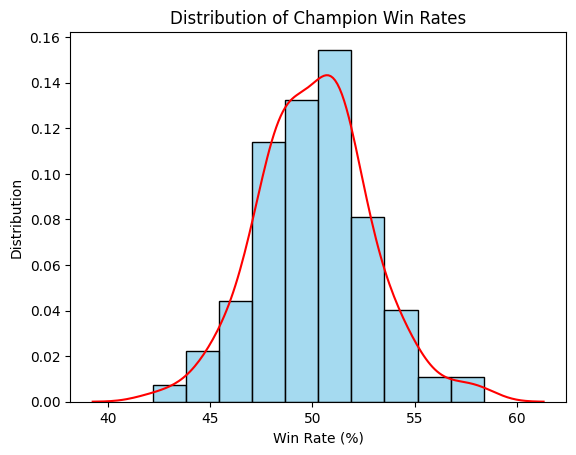

In [9]:
sns.histplot(data=champion_winrate, bins=10, color='skyblue', edgecolor='black', stat="density")
sns.kdeplot(data=champion_winrate, color="red")
plt.xlabel('Win Rate (%)')
plt.ylabel('Distribution')
plt.title('Distribution of Champion Win Rates')
plt.show()

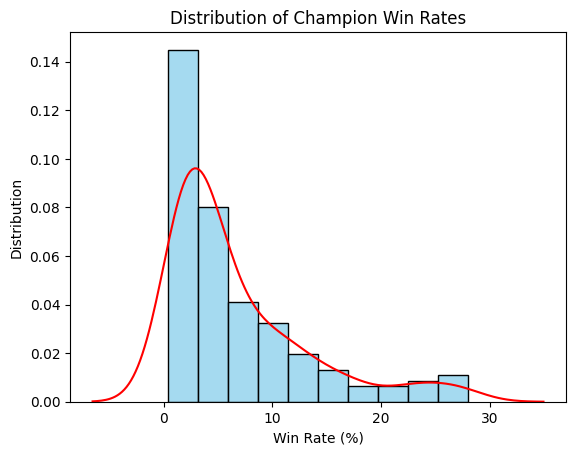

In [7]:
sns.histplot(data=champion_ban_pick_rate, bins=10, color='skyblue', edgecolor='black', stat="density")
sns.kdeplot(data=champion_ban_pick_rate, color="red")
plt.xlabel('Win Rate (%)')
plt.ylabel('Distribution')
plt.title('Distribution of Champion Win Rates')
plt.show()

### 5.2. Champion's Winrate and Ban/Pick Rate in Each Role

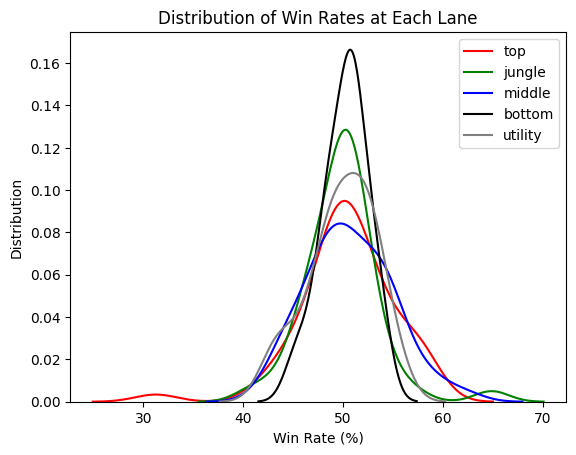

In [28]:
# Finally, we plot all the winrate at each lane

sns.kdeplot(data=top_graph_winrate, color="red")
sns.kdeplot(data=jungle_graph_winrate, color="green")
sns.kdeplot(data=middle_graph_winrate, color="blue")
sns.kdeplot(data=bottom_graph_winrate, color="black")
sns.kdeplot(data=utility_graph_winrate, color="grey")

plt.legend(['top', 'jungle', 'middle', 'bottom', 'utility'])
plt.xlabel('Win Rate (%)')
plt.ylabel('Distribution')
plt.title('Distribution of Win Rates at Each Lane')
plt.show()

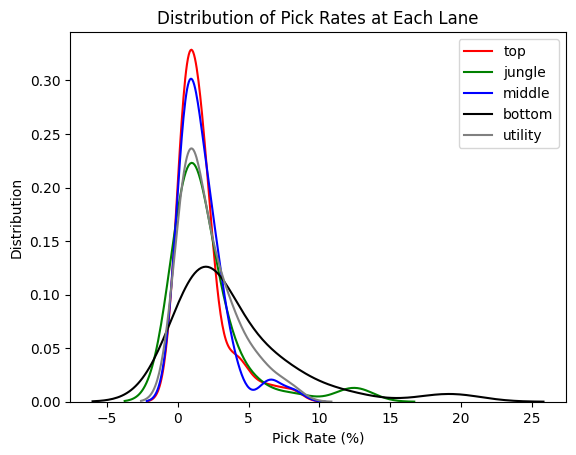

In [27]:
# Finally, we plot all the winrate at each lane

sns.kdeplot(data=top_graph_pickrate, color="red")
sns.kdeplot(data=jungle_graph_pickrate, color="green")
sns.kdeplot(data=middle_graph_pickrate, color="blue")
sns.kdeplot(data=bottom_graph_pickrate, color="black")
sns.kdeplot(data=utility_graph_pickrate, color="grey")

plt.legend(['top', 'jungle', 'middle', 'bottom', 'utility'])
plt.xlabel('Pick Rate (%)')
plt.ylabel('Distribution')
plt.title('Distribution of Pick Rates at Each Lane')
plt.show()

### 5.3. Top Champions with Highest Winrate, Pickrate in Each Lane

In [29]:
highest_champions_winrate = champion_winrate.nlargest(20).apply(lambda x: f'{x*100:.2f}%').str.rstrip('%').astype(float)
highest_top_champions_winrate = top_champions_winrate.nlargest(20).apply(lambda x: f'{x*100:.2f}%').str.rstrip('%').astype(float)
highest_jungle_champions_winrate = jungle_champions_winrate.nlargest(20).apply(lambda x: f'{x*100:.2f}%').str.rstrip('%').astype(float)
highest_middle_champions_winrate = middle_champions_winrate.nlargest(20).apply(lambda x: f'{x*100:.2f}%').str.rstrip('%').astype(float)
highest_bottom_champions_winrate = bottom_champions_winrate.nlargest(20).apply(lambda x: f'{x*100:.2f}%').str.rstrip('%').astype(float)
highest_utility_champions_winrate = utility_champions_winrate.nlargest(20).apply(lambda x: f'{x*100:.2f}%').str.rstrip('%').astype(float)

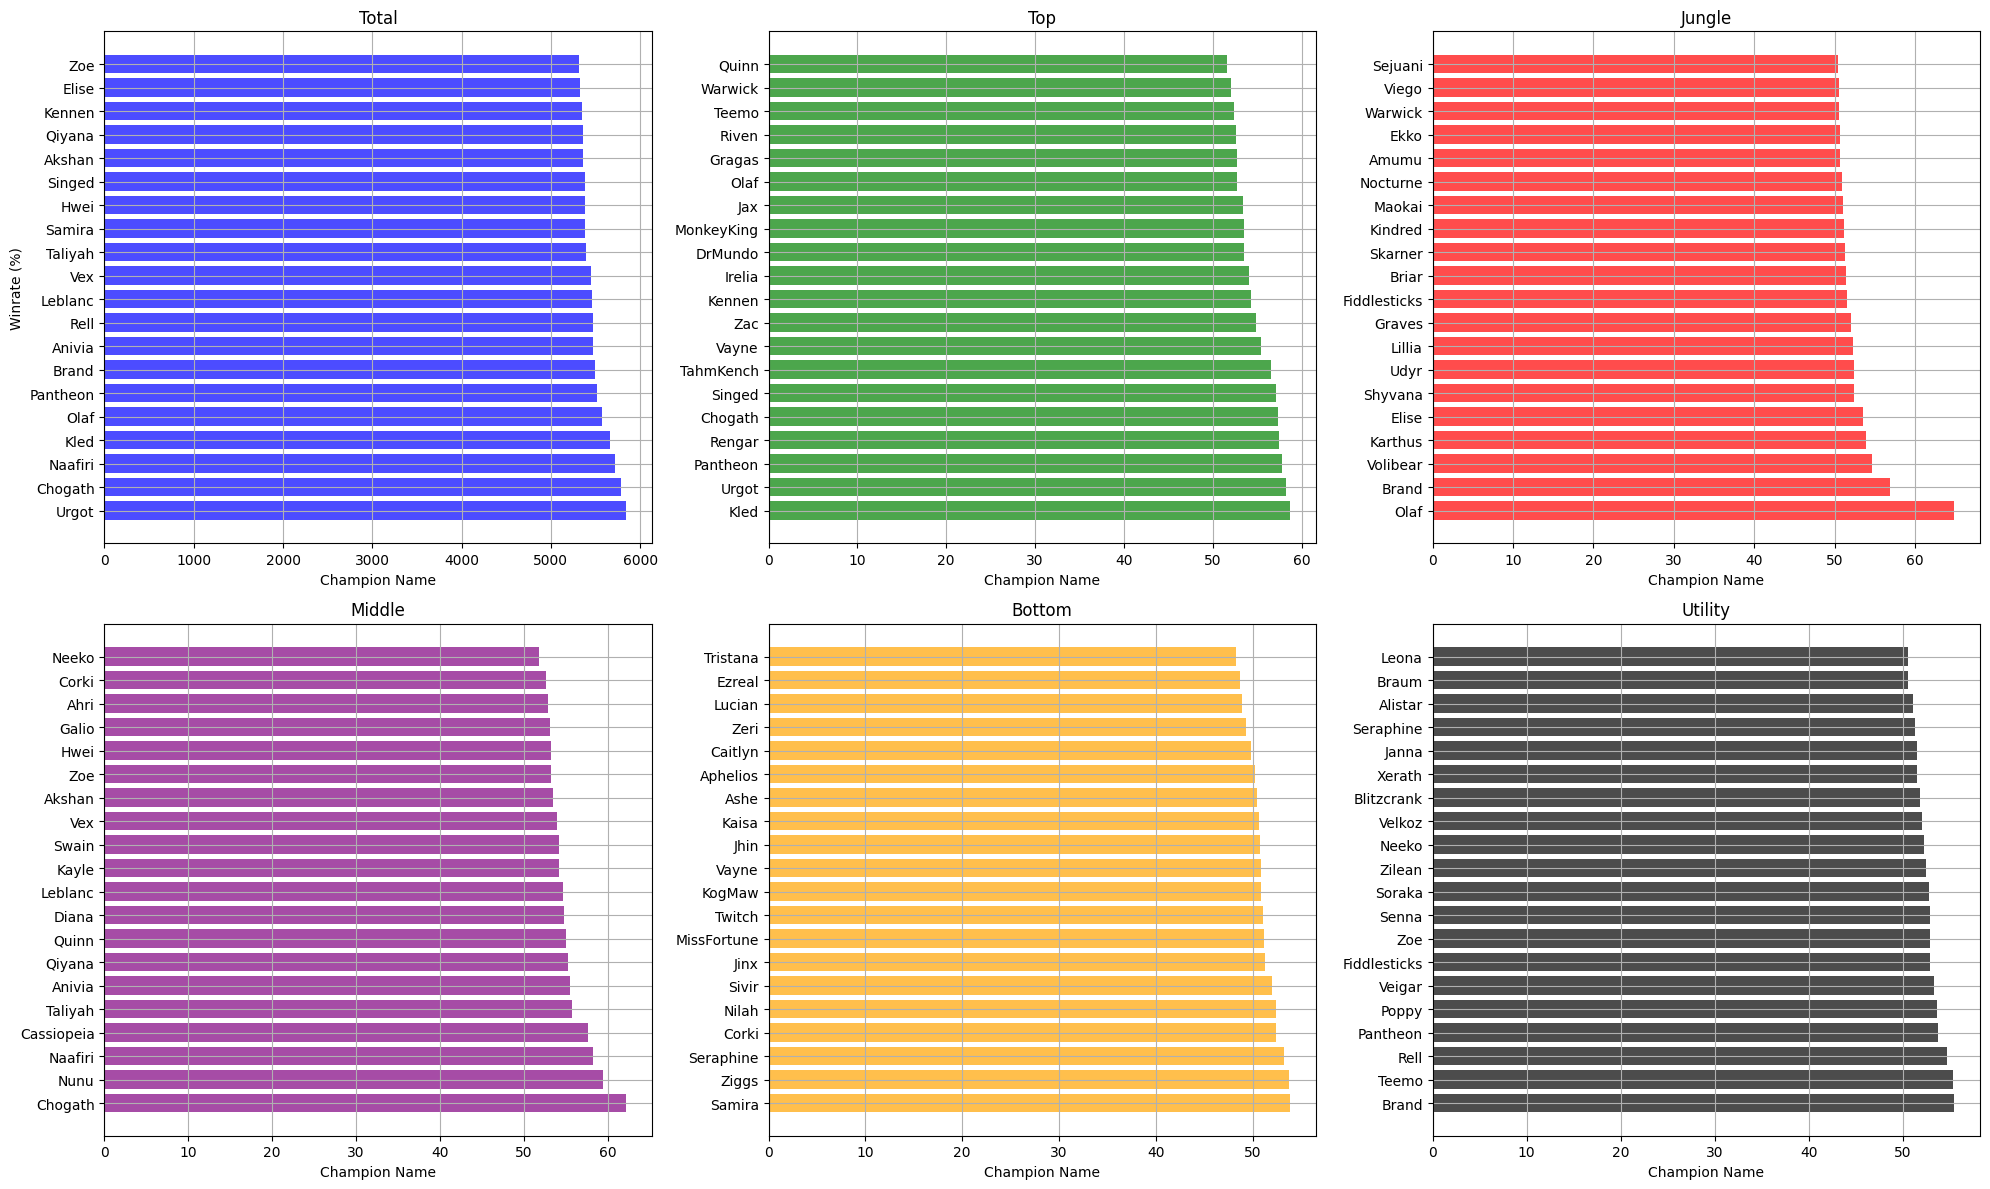

In [32]:
rows, cols = 2, 3
fig, ax = plt.subplots(rows, cols, figsize=(20, 12))

ax[0, 0].barh(highest_champions_winrate.index, highest_champions_winrate.values, color='blue', alpha=0.7)
ax[0, 0].set_title("Total")
ax[0, 0].set_xlabel("Champion Name")
ax[0, 0].set_ylabel("Winrate (%)")
ax[0, 0].grid(True)

ax[0, 1].barh(highest_top_champions_winrate.index, highest_top_champions_winrate.values, color='green', alpha=0.7)
ax[0, 1].set_title("Top")
ax[0, 1].set_xlabel("Champion Name")
ax[0, 1].grid(True)

ax[0, 2].barh(highest_jungle_champions_winrate.index, highest_jungle_champions_winrate.values, color='red', alpha=0.7)
ax[0, 2].set_title("Jungle")
ax[0, 2].set_xlabel("Champion Name")
ax[0, 2].grid(True)

ax[1, 0].barh(highest_middle_champions_winrate.index, highest_middle_champions_winrate.values, color='purple', alpha=0.7)
ax[1, 0].set_title("Middle")
ax[1, 0].set_xlabel("Champion Name")
ax[1, 0].grid(True)

ax[1, 1].barh(highest_bottom_champions_winrate.index, highest_bottom_champions_winrate.values, color='orange', alpha=0.7)
ax[1, 1].set_title("Bottom")
ax[1, 1].set_xlabel("Champion Name")
ax[1, 1].grid(True)

ax[1, 2].barh(highest_utility_champions_winrate.index, highest_utility_champions_winrate.values, color='black', alpha=0.7)
ax[1, 2].set_title("Utility")
ax[1, 2].set_xlabel("Champion Name")
ax[1, 2].grid(True)

plt.tight_layout()
plt.show()

In [33]:
highest_champions_pickrate = champion_ban_pick_rate.nlargest(20).apply(lambda x: f'{x*100:.2f}%').str.rstrip('%').astype(float)
highest_top_champions_pickrate = top_champions_pickrate.nlargest(20).apply(lambda x: f'{x*100:.2f}%').str.rstrip('%').astype(float)
highest_jungle_champions_pickrate = jungle_champions_pickrate.nlargest(20).apply(lambda x: f'{x*100:.2f}%').str.rstrip('%').astype(float)
highest_middle_champions_pickrate = middle_champions_pickrate.nlargest(20).apply(lambda x: f'{x*100:.2f}%').str.rstrip('%').astype(float)
highest_bottom_champions_pickrate = bottom_champions_pickrate.nlargest(20).apply(lambda x: f'{x*100:.2f}%').str.rstrip('%').astype(float)
highest_utility_champions_pickrate = utility_champions_pickrate.nlargest(20).apply(lambda x: f'{x*100:.2f}%').str.rstrip('%').astype(float)

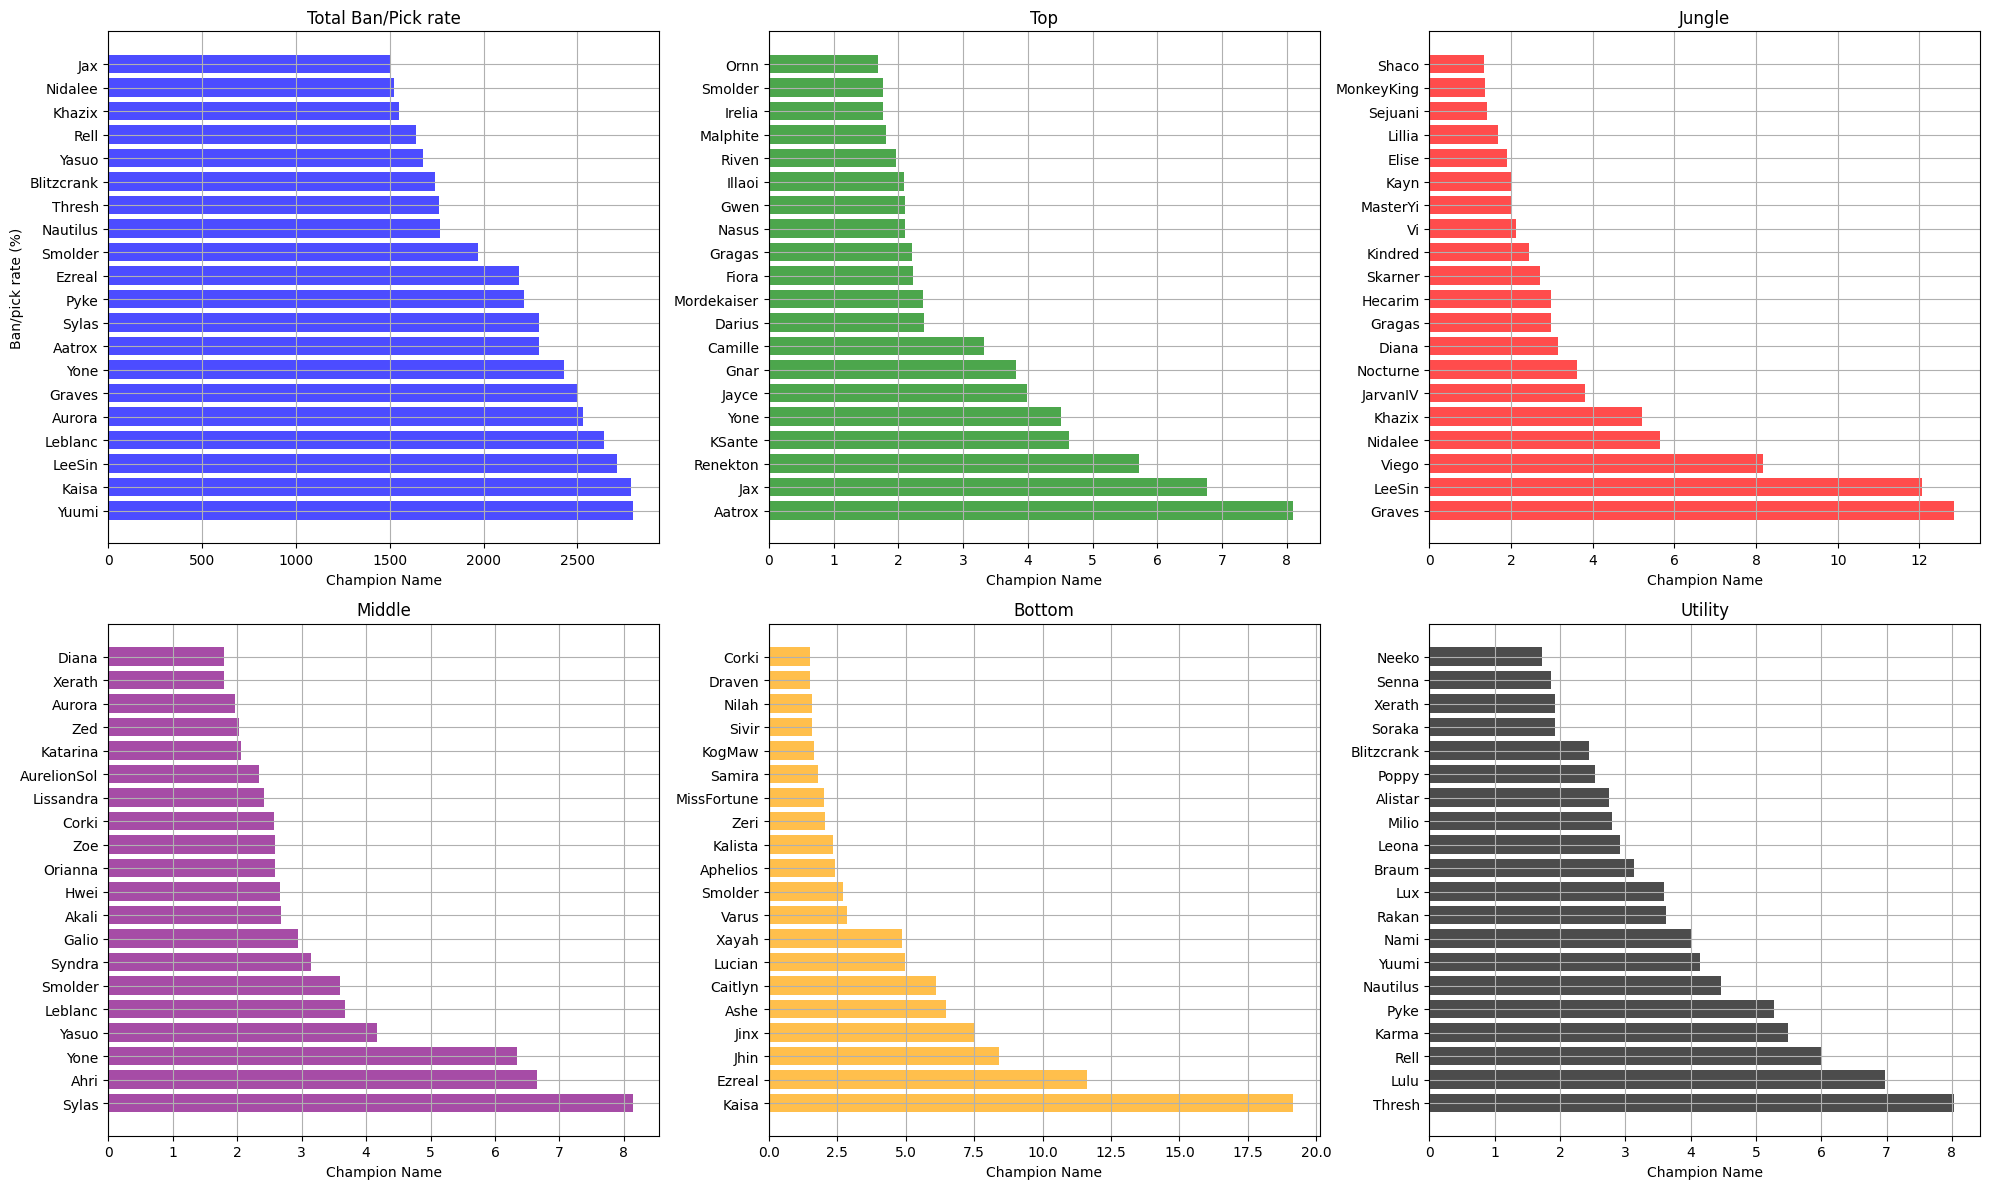

In [34]:
rows, cols = 2, 3
fig, ax = plt.subplots(rows, cols, figsize=(20, 12))

ax[0, 0].barh(highest_champions_pickrate.index, highest_champions_pickrate.values, color='blue', alpha=0.7)
ax[0, 0].set_title("Total Ban/Pick rate")
ax[0, 0].set_xlabel("Champion Name")
ax[0, 0].set_ylabel("Ban/pick rate (%)")
ax[0, 0].grid(True)

ax[0, 1].barh(highest_top_champions_pickrate.index, highest_top_champions_pickrate.values, color='green', alpha=0.7)
ax[0, 1].set_title("Top")
ax[0, 1].set_xlabel("Champion Name")
ax[0, 1].grid(True)

ax[0, 2].barh(highest_jungle_champions_pickrate.index, highest_jungle_champions_pickrate.values, color='red', alpha=0.7)
ax[0, 2].set_title("Jungle")
ax[0, 2].set_xlabel("Champion Name")
ax[0, 2].grid(True)

ax[1, 0].barh(highest_middle_champions_pickrate.index, highest_middle_champions_pickrate.values, color='purple', alpha=0.7)
ax[1, 0].set_title("Middle")
ax[1, 0].set_xlabel("Champion Name")
ax[1, 0].grid(True)

ax[1, 1].barh(highest_bottom_champions_pickrate.index, highest_bottom_champions_pickrate.values, color='orange', alpha=0.7)
ax[1, 1].set_title("Bottom")
ax[1, 1].set_xlabel("Champion Name")
ax[1, 1].grid(True)

ax[1, 2].barh(highest_utility_champions_pickrate.index, highest_utility_champions_pickrate.values, color='black', alpha=0.7)
ax[1, 2].set_title("Utility")
ax[1, 2].set_xlabel("Champion Name")
ax[1, 2].grid(True)

plt.tight_layout()
plt.show()

### 5.4. Game Duration Distribution

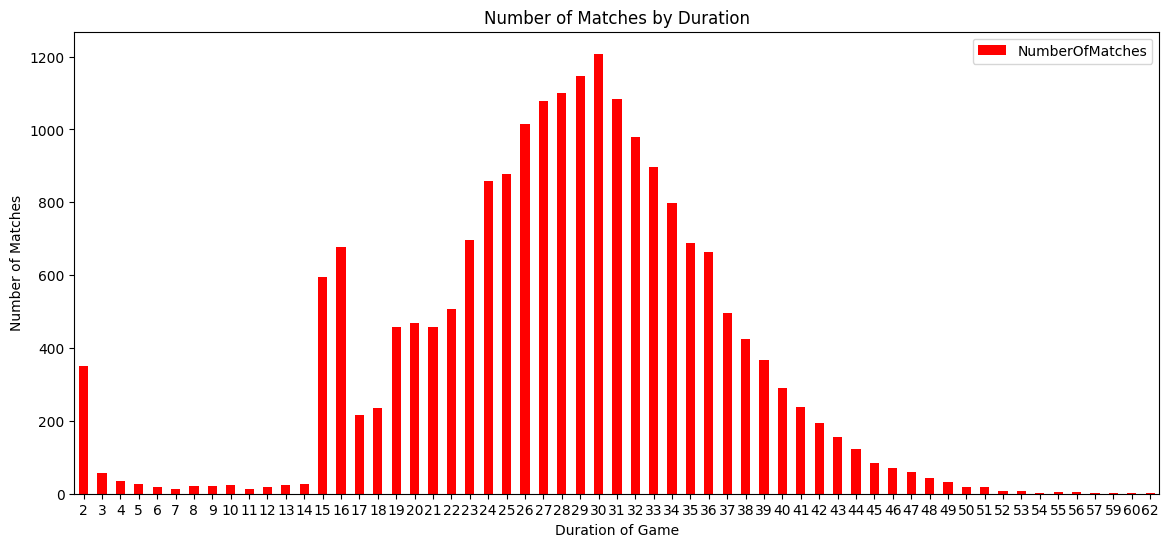

In [ ]:
game_duration_df = pd.read_csv('csv/game_duration.csv')
ax = game_duration_df.plot(kind="bar", x = "Duration" ,color="red", figsize=(14, 6))
ax.tick_params(rotation = 0)
ax.set_title("Number of Matches by Duration")
ax.set_xlabel("Duration of Game")
ax.set_ylabel("Number of Matches")

plt.show()

### 5.5. Number of Matches by Hour

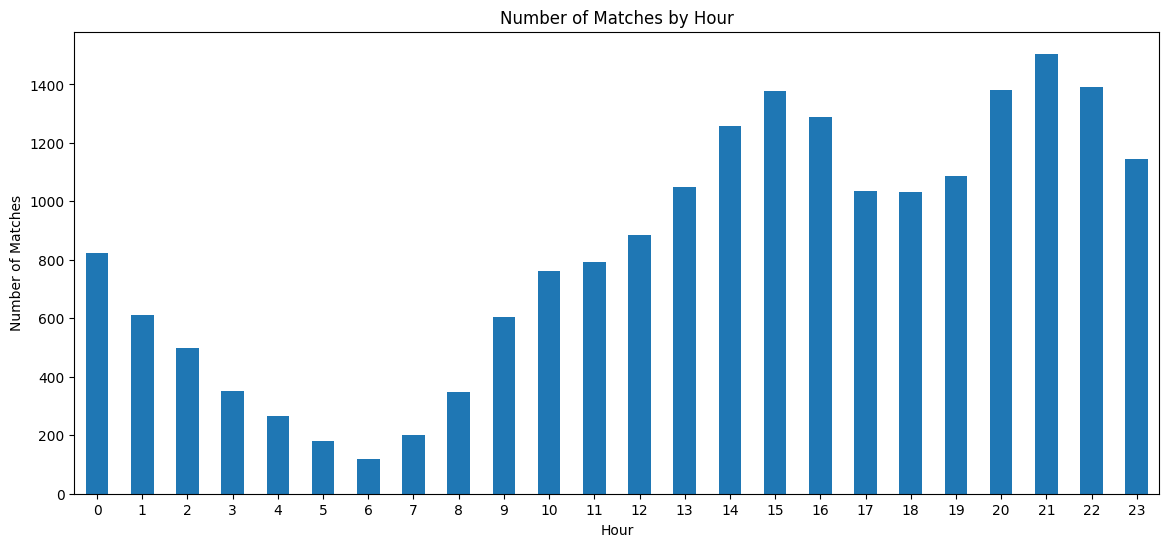

In [ ]:
game_time_graph = get_time_distribution()
ax = game_time_graph.plot(kind='bar', figsize=(14, 6))
ax.tick_params(rotation = 0)
ax.set_title("Number of Matches by Hour")
ax.set_xlabel("Hour")
ax.set_ylabel("Number of Matches")

plt.show()

### 5.6. Champion Tier List Distribution

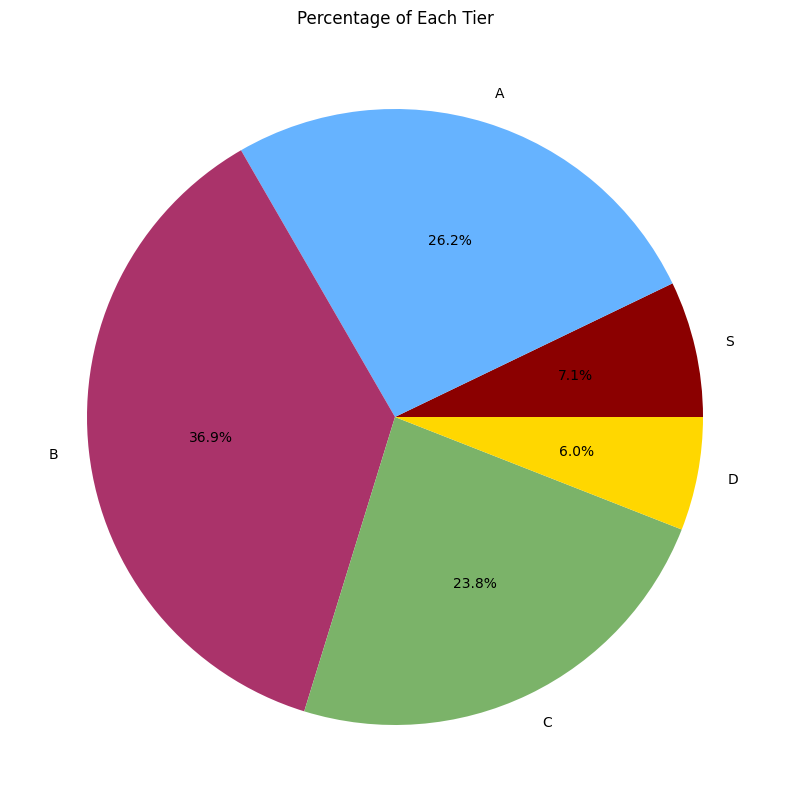

In [ ]:

tier = list(tier_list.keys())
percentage = [len(values) for values in tier_list.values()]
pie_colors = ['#8b0000', '#66B3FF', '#AA336A', '#7BB369', '#FFD700']

plt.figure(figsize=(10, 10))
plt.pie(percentage, labels=tier, autopct='%1.1f%%', colors=pie_colors)
plt.title("Percentage of Each Tier")
plt.show()

### 5.7. Roles' Popularity

<Axes: >

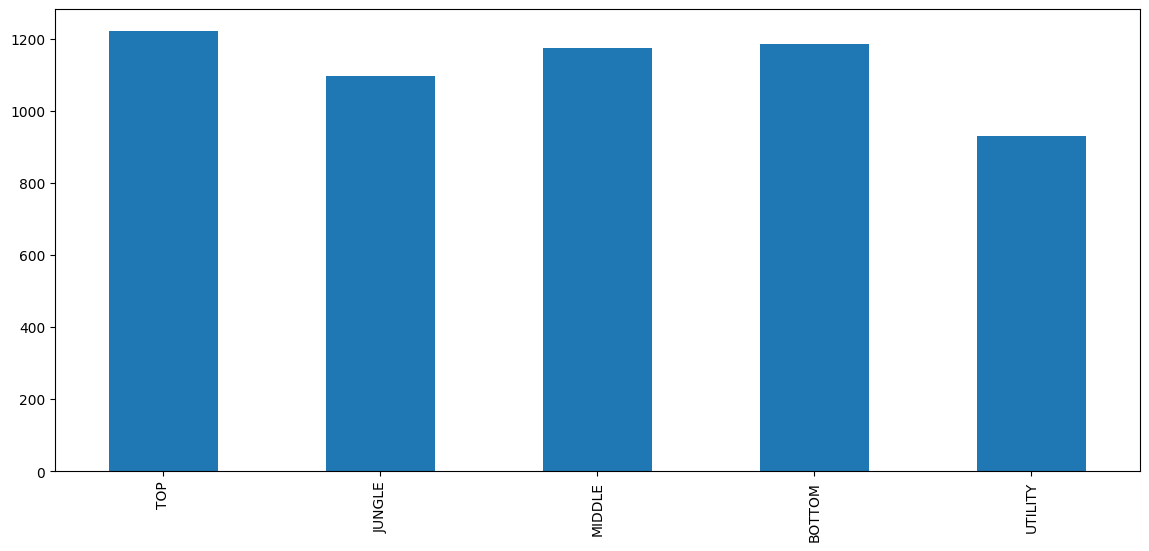

In [5]:
main_role.plot(kind='bar', figsize=(14, 6))

<Axes: >

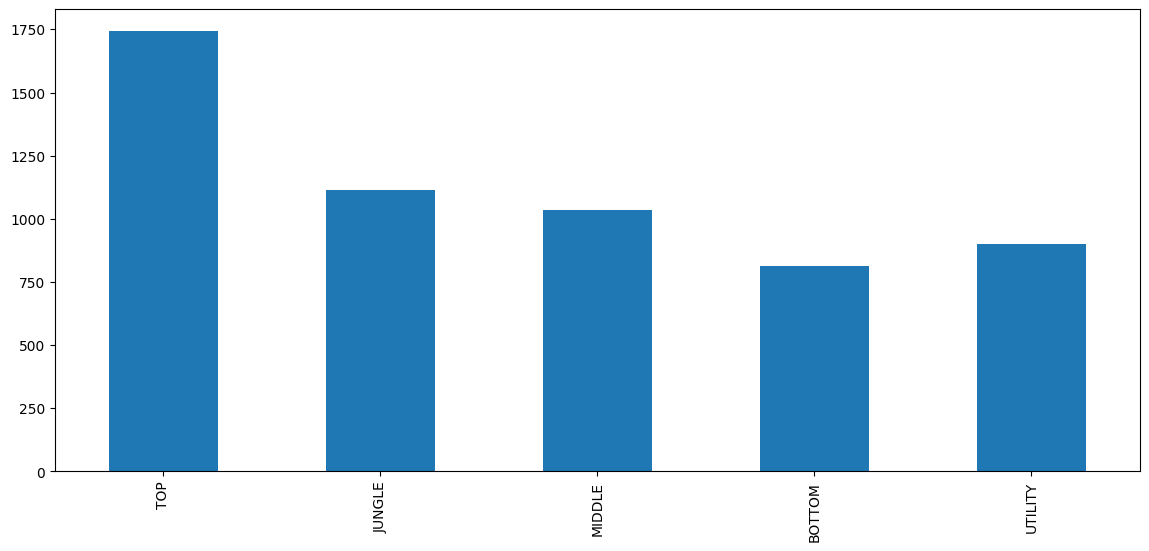

In [6]:
sub_role.plot(kind='bar', figsize=(14, 6))

### 5.8. Winrate based on each Objective in the game

In [38]:
def getBarGraph(objective: str, color: str, output: str):
    winrate_objective = pd.read_csv('csv/winrate_objective.csv', index_col=0)
    ax = winrate_objective[objective].plot(kind='line', figsize=(20, 8), color=color)
    for i, v in enumerate(winrate_objective[objective].values):
        ax.text(i, v + 0.02, f'{v:.2f}', ha='center')
        
    ax.set_xlabel('Rank')  
    ax.set_ylabel('Win Rate (%)')   
    ax.set_title('Win Rate with ' + output) 
    ax.set_xticks(range(len(winrate_objective.index)))
    ax.set_xticklabels(winrate_objective.index, rotation=15)
    plt.show()

def getDoubleBarGraph(objective1: str, objective2: str, color: list, output: str):
    winrate_objective = pd.read_csv('csv/winrate_objective.csv', index_col=0)
    ax = winrate_objective[[objective1, objective2]].plot(kind='line', figsize=(20, 8), color=color)

    for i, (val1, val2) in enumerate(zip(winrate_objective[objective1], winrate_objective[objective2])):
        ax.text(i - 0.15, val1 + 0.02, f'{val1:.2f}', ha='center')  
        ax.text(i + 0.15, val2 + 0.02, f'{val2:.2f}', ha='center')  
    
    ax.set_xlabel('Rank')  
    ax.set_ylabel('Win Rate (%)')   
    ax.set_title('Win Rate with ' + output) 
    ax.set_xticks(range(len(winrate_objective.index)))
    ax.set_xticklabels(winrate_objective.index, rotation=15)
    plt.show()

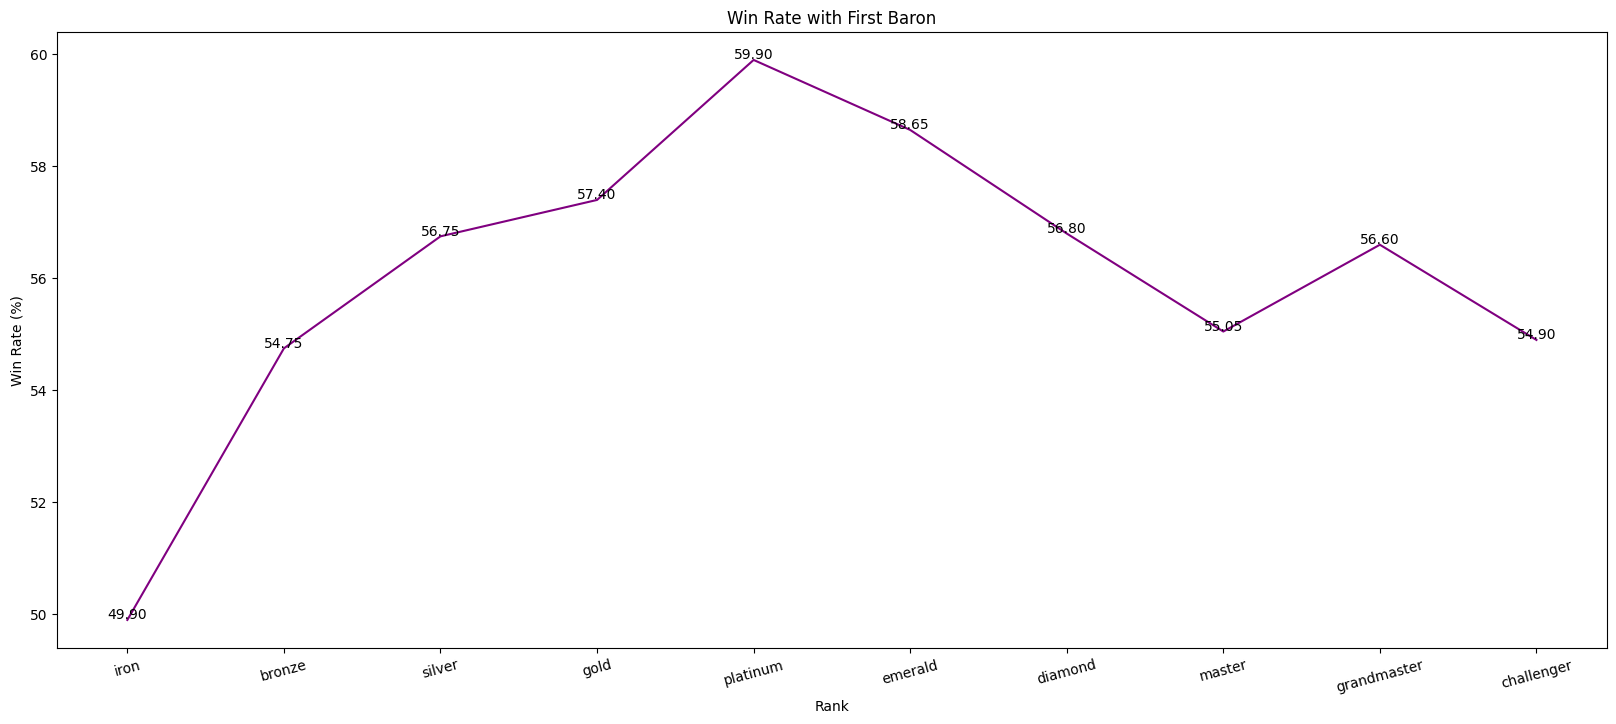

In [39]:
first_baron_graph = getBarGraph("first_baron", "purple", "First Baron")

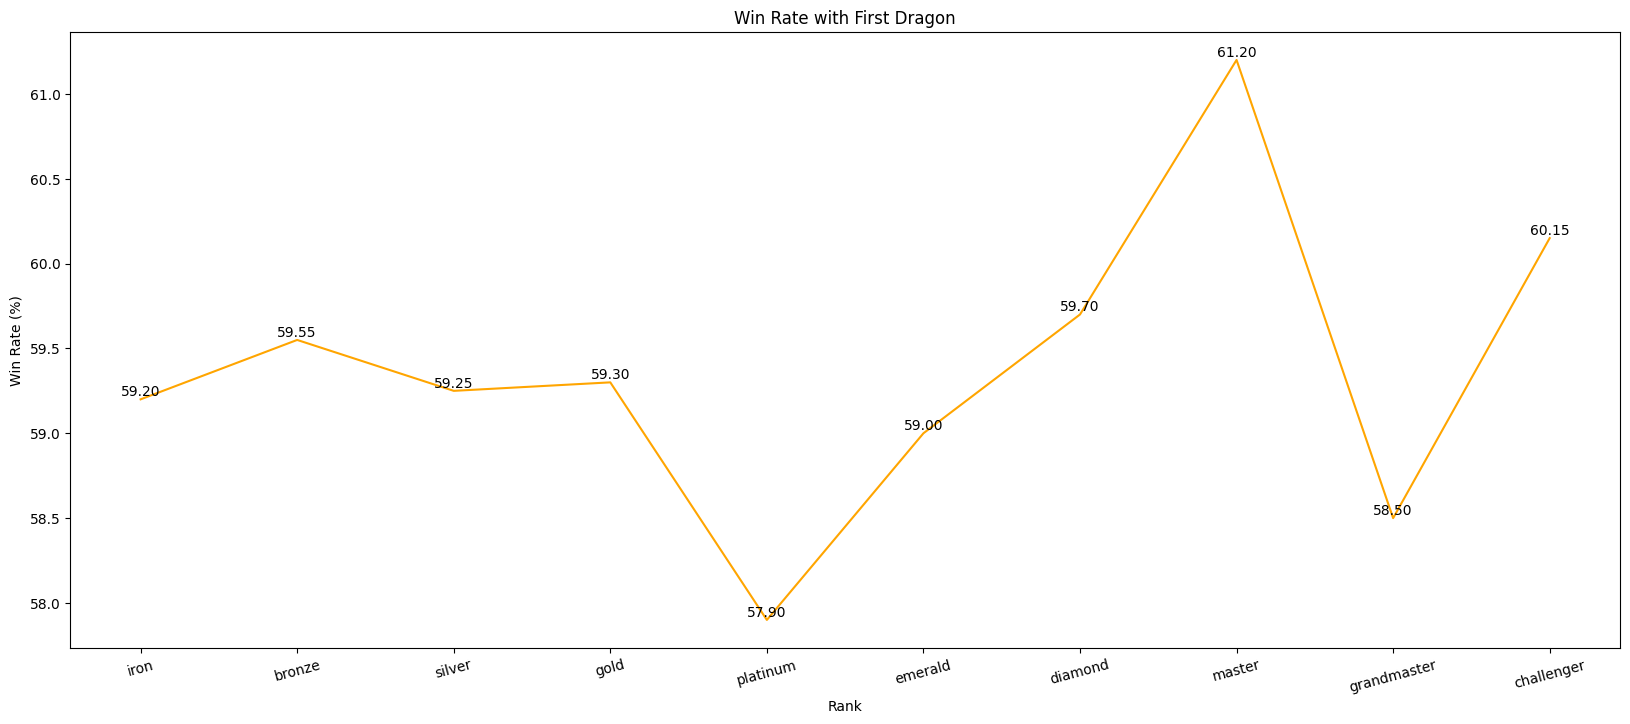

In [40]:
first_dragon_graph = getBarGraph("first_dragon", "orange", "First Dragon")

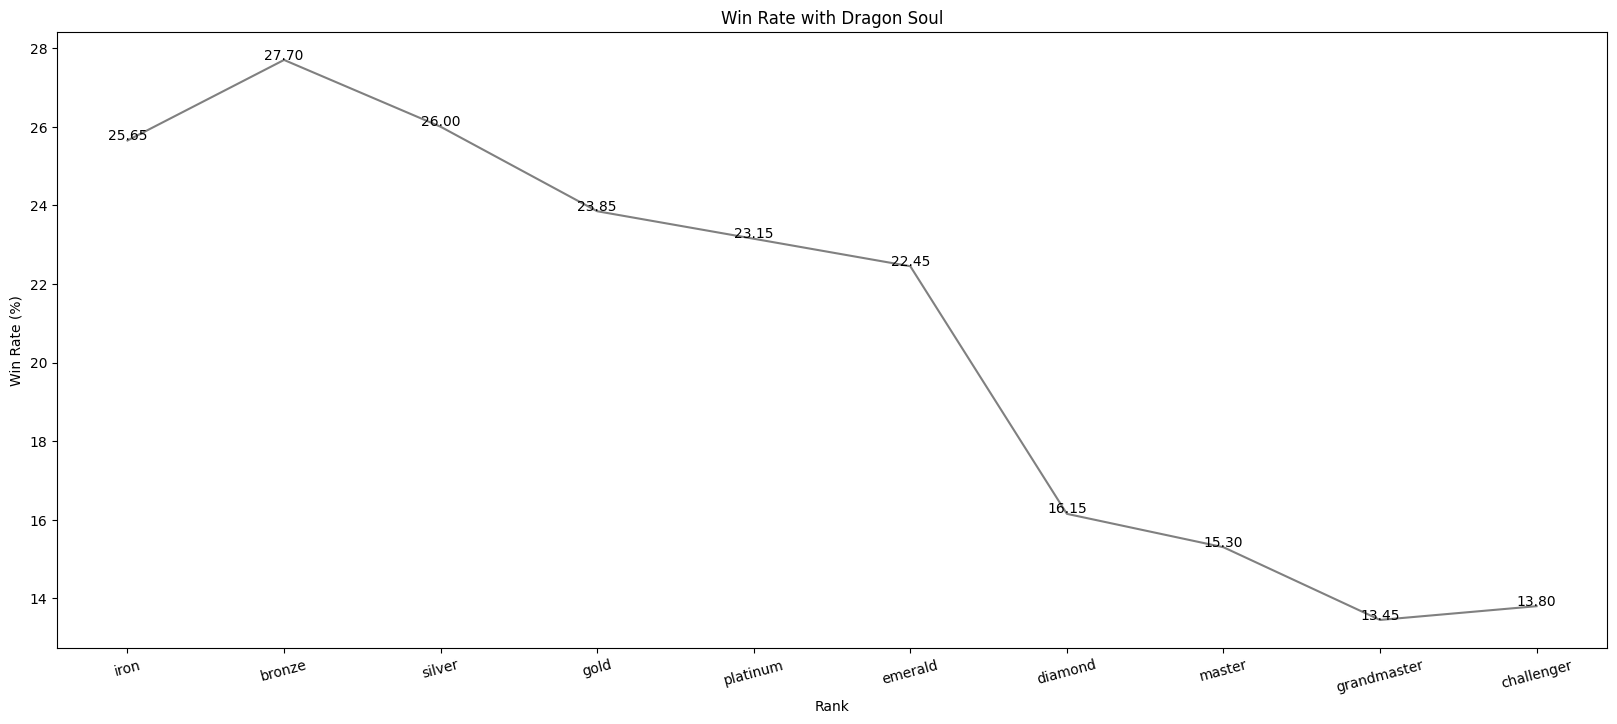

In [41]:
dragon_soul_graph = getBarGraph('dragon_soul', 'grey', 'Dragon Soul')

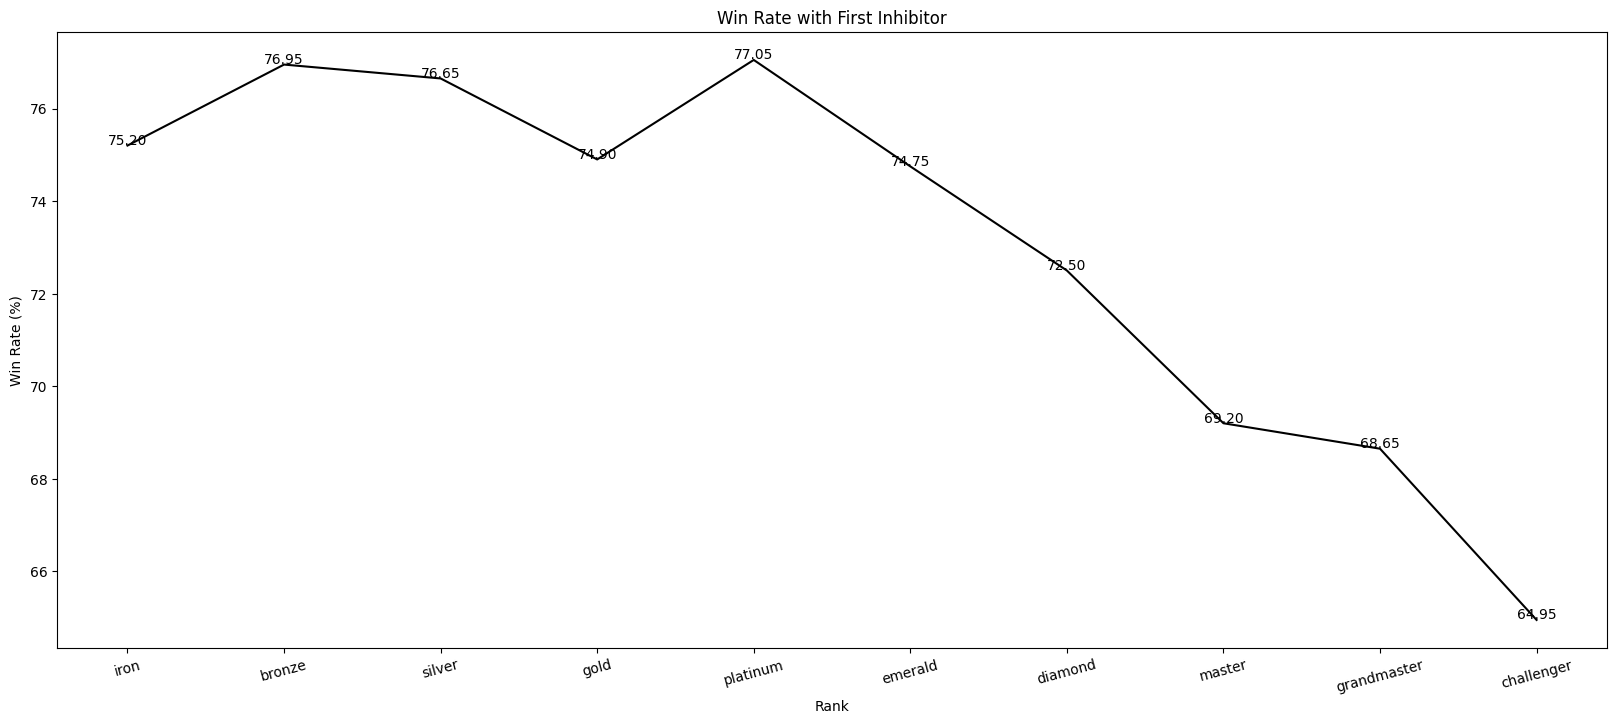

In [44]:
first_inhibitor_graph = getBarGraph('first_inhibitor', 'black', 'First Inhibitor')

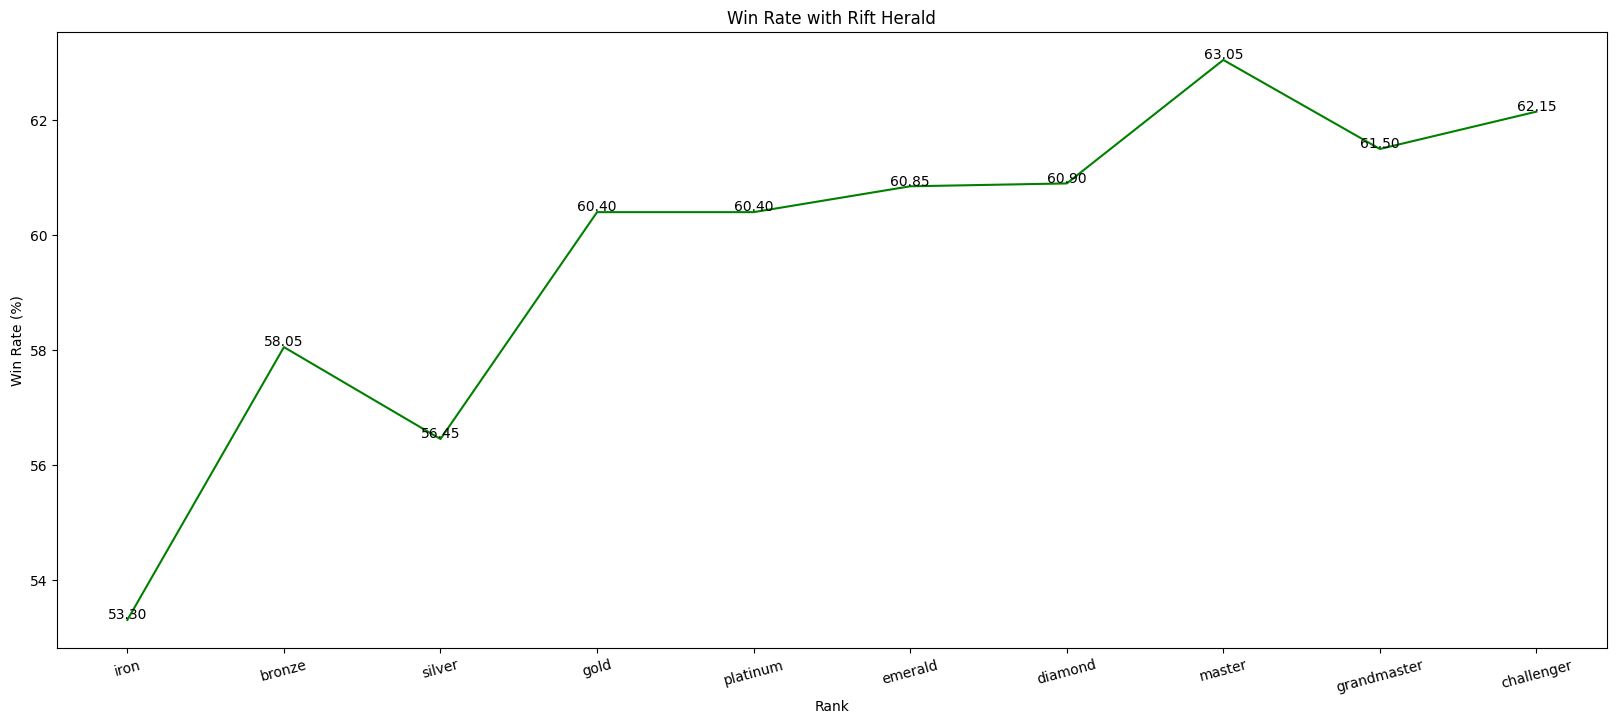

In [45]:
rift_herald_graph = getBarGraph("rift_herald", "green", "Rift Herald")

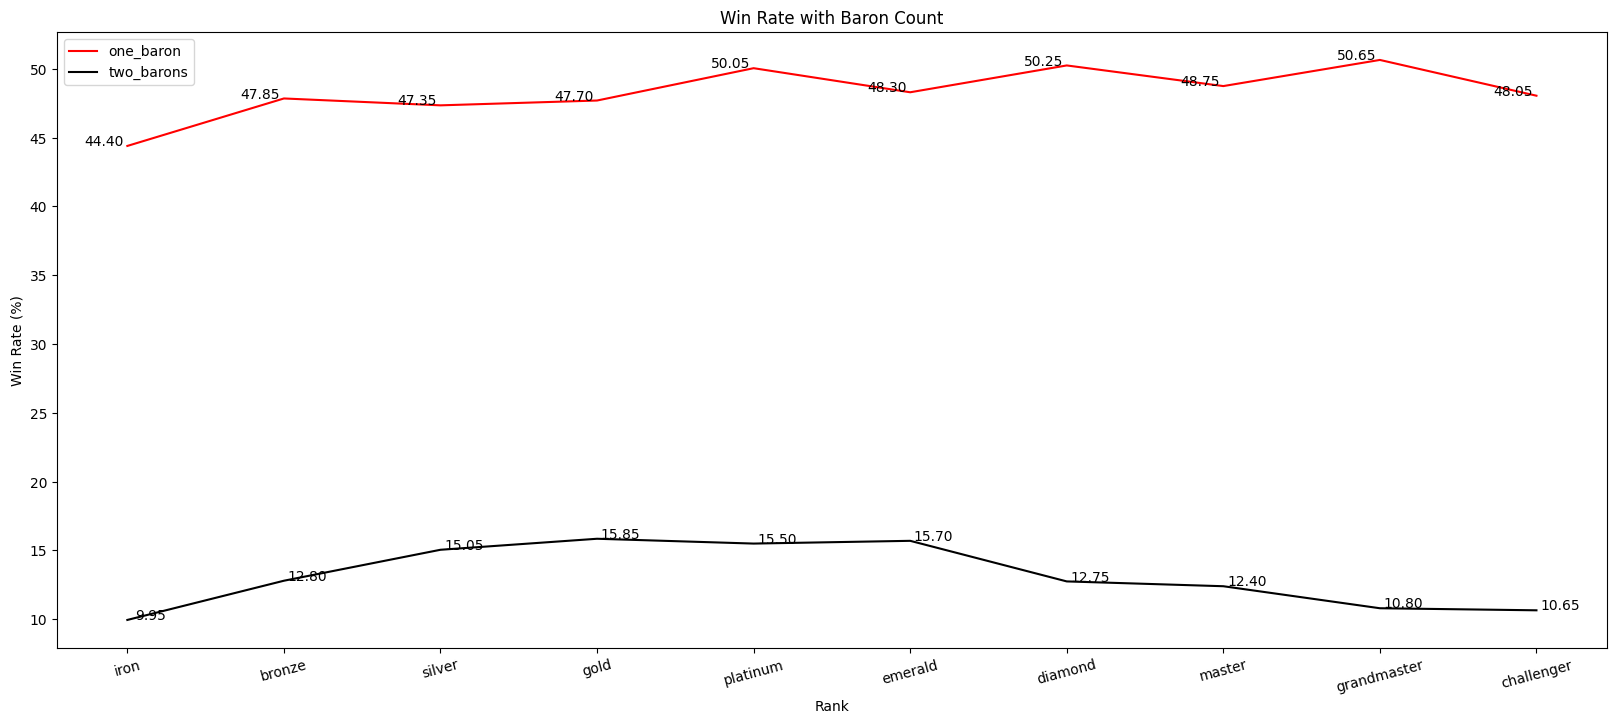

In [46]:
baron_stat = getDoubleBarGraph("one_baron", "two_barons", ["red", "black"], "Baron Count")

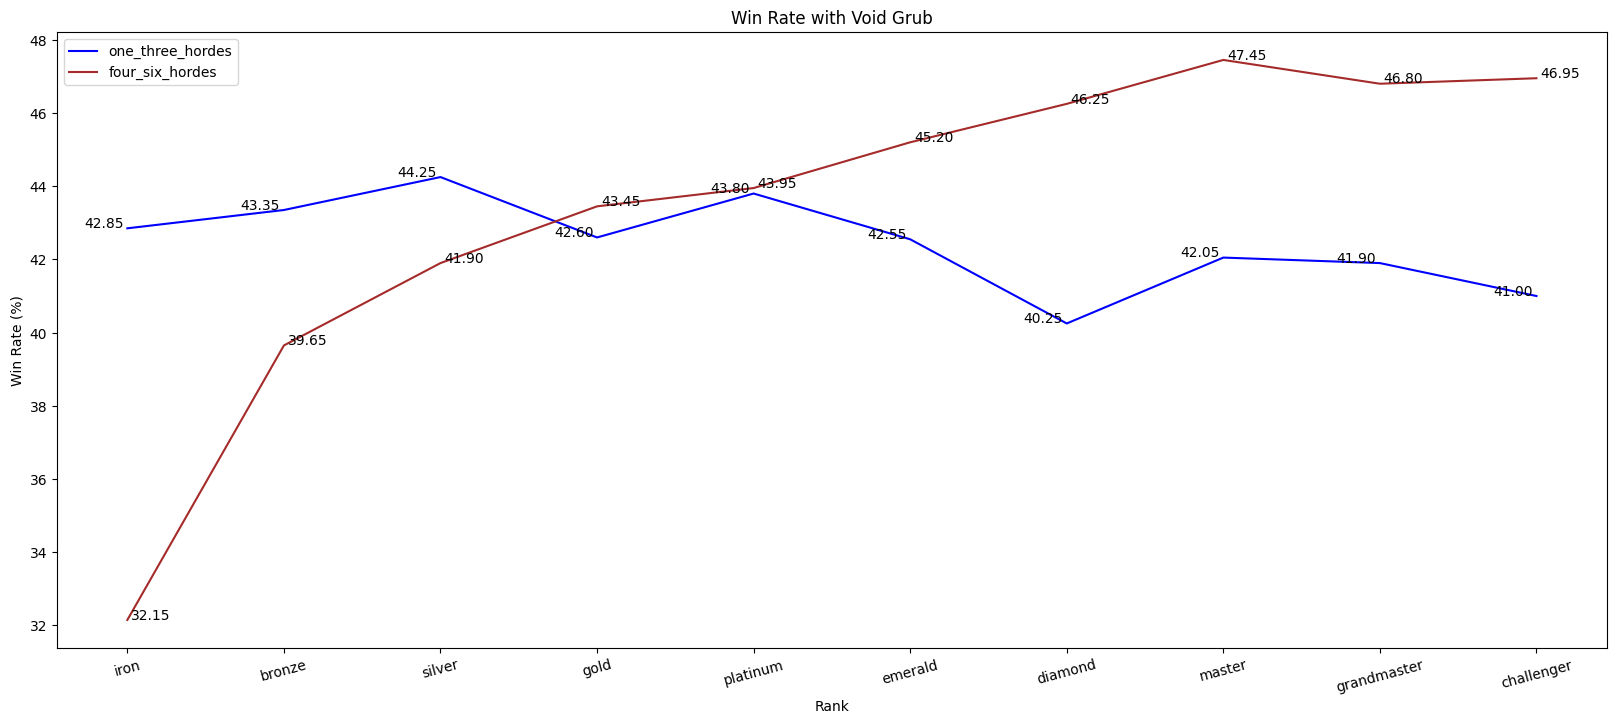

In [47]:
voidgrub_stat = getDoubleBarGraph("one_three_hordes", "four_six_hordes", ["blue", "brown"], "Void Grub")

## 6. A very simple, naive prediction model

In [15]:
data = pd.read_csv('csv/ml.csv', index_col= 0)

In [16]:
data = data.replace(-1, 2)
data

,266,103,84,166,12,32,34,1,523,22,...,83,350,154,238,221,115,26,142,143,winner
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,0,0,0,0,0,0,0,0,2,0,...,0,1,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,1
11996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
11997,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
11998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [17]:
X, y = data.iloc[:, :-1], data.iloc[:, -1]

In [18]:
y

0        1
1        2
2        2
3        1
4        1
        ..
11995    1
11996    1
11997    1
11998    1
11999    2
Name: winner, Length: 12000, dtype: int64

In [19]:
# split test and fit model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, stratify= y, random_state= 1)
model = naive_bayes.CategoricalNB()
model.fit(X_train, y_train)

CategoricalNB()

In [20]:
# predict the win probability of 2 team, team 1 and team 2, team 1 is blue, team 2 is red
prob = model.predict_proba(X_train)
prob

array([[0.58723547, 0.41276453],
       [0.29930112, 0.70069888],
       [0.56376965, 0.43623035],
       ...,
       [0.52307808, 0.47692192],
       [0.51834066, 0.48165934],
       [0.70533755, 0.29466245]])

In [21]:
# predict the match result
pred = model.predict(X_train)
pred

array([1, 2, 1, ..., 1, 1, 1])

In [22]:
# model accuracy on test data
model.score(X_test, y_test)

0.5102777777777778

$\to$ So, our model's accuracy is at 51.03%